# NYC Taxi Fare Prediction - EDA for Full Model

In [1]:
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sin, cos, sqrt, atan2, radians
import warnings
warnings.filterwarnings('ignore')

## Import Data

Functions for importing data.

Big Query has trouble hashing on row number, so hash on column with all unique values - e.g., pickup datetime - for repeatable splitting of dataset.  

In [2]:
def import_yearly_data(year, sample_frac = .001):
    query = '''
    SELECT *
    FROM
        (
        SELECT 
            *,
            FARM_FINGERPRINT(CAST(tpep_pickup_datetime AS STRING)) AS hashrow
        FROM
            nyctaxi-284709.tlc_yellow_trips_{}.tlc_yellow_trips_{}
        )
        WHERE 
            ABS(MOD(hashrow, CAST(1/{} AS INT64))) = 1
    '''.format(year, year, sample_frac)
    df = bigquery.Client().query(query).to_dataframe()
    return df

def import_geom_data():
    query_geom = """
    SELECT *
    FROM
        nyctaxi-284709.taxi_zone_geom.taxi_zone_geom
    """
    df_geom = bigquery.Client().query(query_geom).to_dataframe()
    return df_geom

In [3]:
df_raw = import_yearly_data(2017, sample_frac = .01)

In [4]:
df_geom_raw = import_geom_data()

In [5]:
df_raw.head()

VendorID      tpep_pickup_datetime     tpep_dropoff_datetime  \
0         2 2017-05-01 07:09:22+00:00 2017-05-01 07:18:07+00:00   
1         2 2017-05-01 10:19:40+00:00 2017-05-01 10:35:33+00:00   
2         2 2017-05-01 14:25:16+00:00 2017-05-01 14:37:20+00:00   
3         1 2017-05-01 16:13:59+00:00 2017-05-01 16:53:58+00:00   
4         2 2017-01-25 09:16:29+00:00 2017-01-25 09:29:14+00:00   

   passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0                1           1.39           1               False   
1                6           1.79           1               False   
2                6           1.35           1               False   
3                1           5.00           1               False   
4                1           1.62           1               False   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           140           162             2          7.5    0.0      0.5   
1           162           236             1         11.5    0.0      0.5   
2           236           239             1          9.5    0.0      0.5   
3           161            13             1         26.0    1.0      0.5   
4           186           163             1          9.5    0.0      0.5   

   tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0        0.00           0.0                    0.3          8.30   
1        1.00           0.0                    0.3         13.30   
2        2.06           0.0                    0.3         12.36   
3        4.20           0.0                    0.3         32.00   
4        2.58           0.0                    0.3         12.88   

               hashrow  
0  6990513507285881701  
1   665869781167765101  
2  9068619731292269001  
3 -5325181214837575701  
4  1179403990937463401

In [79]:
df_raw.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'hashrow'],
      dtype='object')

In [7]:
df_raw.dtypes

VendorID                               int64
tpep_pickup_datetime     datetime64[ns, UTC]
tpep_dropoff_datetime    datetime64[ns, UTC]
passenger_count                        int64
trip_distance                        float64
RatecodeID                             int64
store_and_fwd_flag                      bool
PULocationID                           int64
DOLocationID                           int64
payment_type                           int64
fare_amount                          float64
extra                                float64
mta_tax                              float64
tip_amount                           float64
tolls_amount                         float64
improvement_surcharge                float64
total_amount                         float64
hashrow                                int64
dtype: object

In [8]:
df_geom_raw.head()

zone_id                zone_name borough  \
0       1           Newark Airport     EWR   
1       3  Allerton/Pelham Gardens   Bronx   
2      18             Bedford Park   Bronx   
3      20                  Belmont   Bronx   
4      31               Bronx Park   Bronx   

                                           zone_geom  
0  POLYGON((-74.1856319999999 40.6916479999999, -...  
1  POLYGON((-73.848596761 40.8716707849999, -73.8...  
2  POLYGON((-73.8844286139999 40.8668003789999, -...  
3  POLYGON((-73.8839239579998 40.8644177609999, -...  
4  POLYGON((-73.8710017319999 40.8572767429999, -...

# Preprocessing

Helper functions for preprocessing. 

In [9]:
# calculate average latitude and longitude of bounding polygon (found in df_geom)
def calculate_center(bounding_polygon):
    
    # remove everything but list of coords from input string
    if bounding_polygon[0] == 'P':
        polygon = bounding_polygon[len('POLYGON(('):-2]
        coords_list = polygon.split(', ')
        coords_list = [coords_list[i].split(' ') for i in range(len(coords_list))]
    elif bounding_polygon[0] == 'M':
        multi_polygon = bounding_polygon[len('MULTIPOLYGON((('):-3]
        polygon_list = multi_polygon.split(')), ((')
        coords_list = []
        for polygon in polygon_list: 
            coords_list_poly = polygon.split(', ')
            coords_list_poly = [coords_list_poly[i].split(' ') for i in range(len(coords_list_poly))]
            coords_list = coords_list + coords_list_poly
    
    L = len(coords_list)
    
    # extract lats and longs and take their average
    lats = [float(coords_list[i][0]) for i in range(len(coords_list))]
    longs = [float(coords_list[i][1]) for i in range(len(coords_list))]
    center = (sum(lats)/float(L), sum(longs)/float(L))
    
    return center

# calculate haversine distance - for small differences in lat/long, this is basically straightline distance - for given
# row, containing PU/DO lat/long. 
def haversine_distance(row):
    # approximate radius of earth in miles
    R = 3960
    
    PU = row['PU_zone_center']
    DO = row['DO_zone_center']
    
    lat1 = radians(PU[0])
    lon1 = radians(PU[1])
    lat2 = radians(DO[0])
    lon2 = radians(DO[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance



Helper functions for model evaluation.

In [10]:
# mean absolute percentage error
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# symmetric mean absolute percentage error
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

## Initial Preprocessing of Data Based on Distance Features

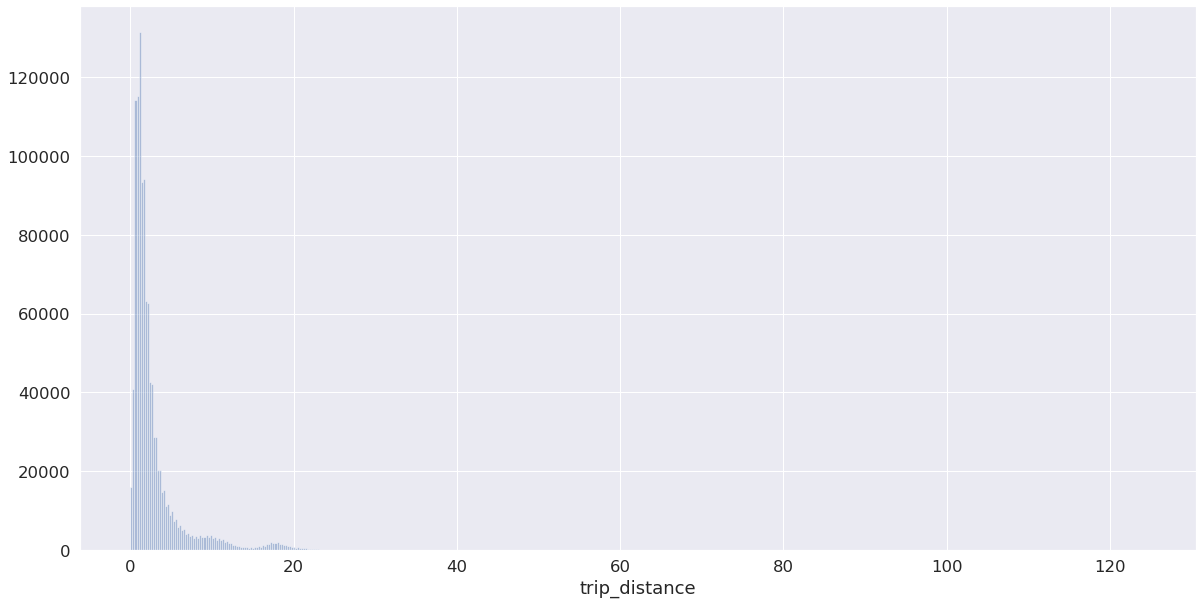

In [104]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df_raw['trip_distance'], bins = 500, kde = False)
plt.show()

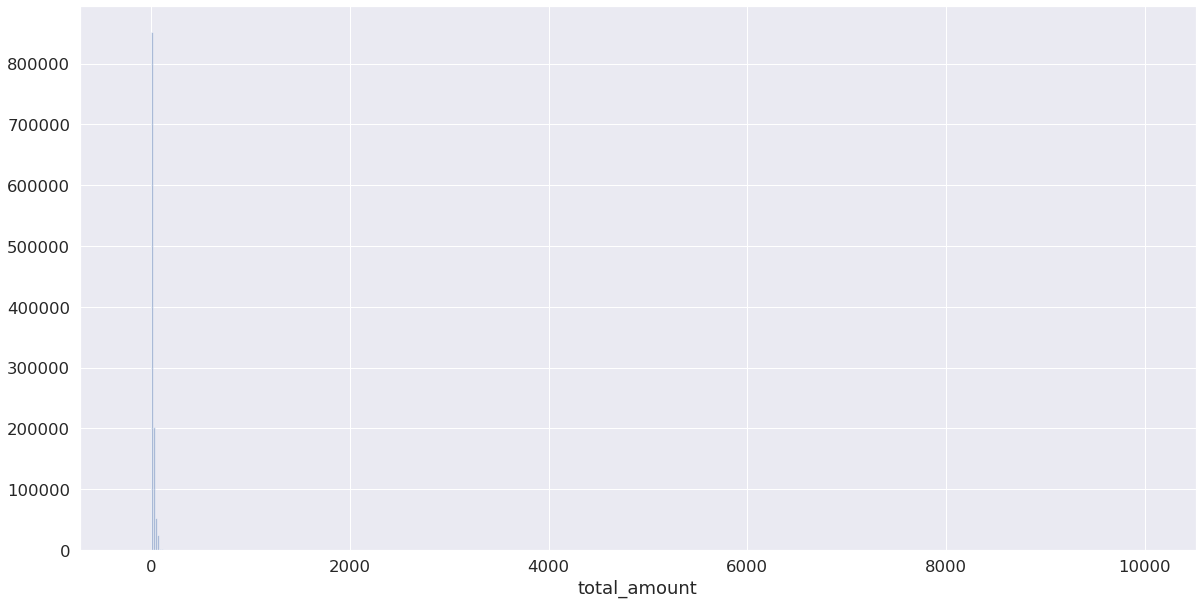

In [105]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df_raw['total_amount'], bins = 500, kde = False)
#plt.xlim(0,200)
plt.show()

Outliers present, limit x axis values. Increase number of bins to show distribution more finely 

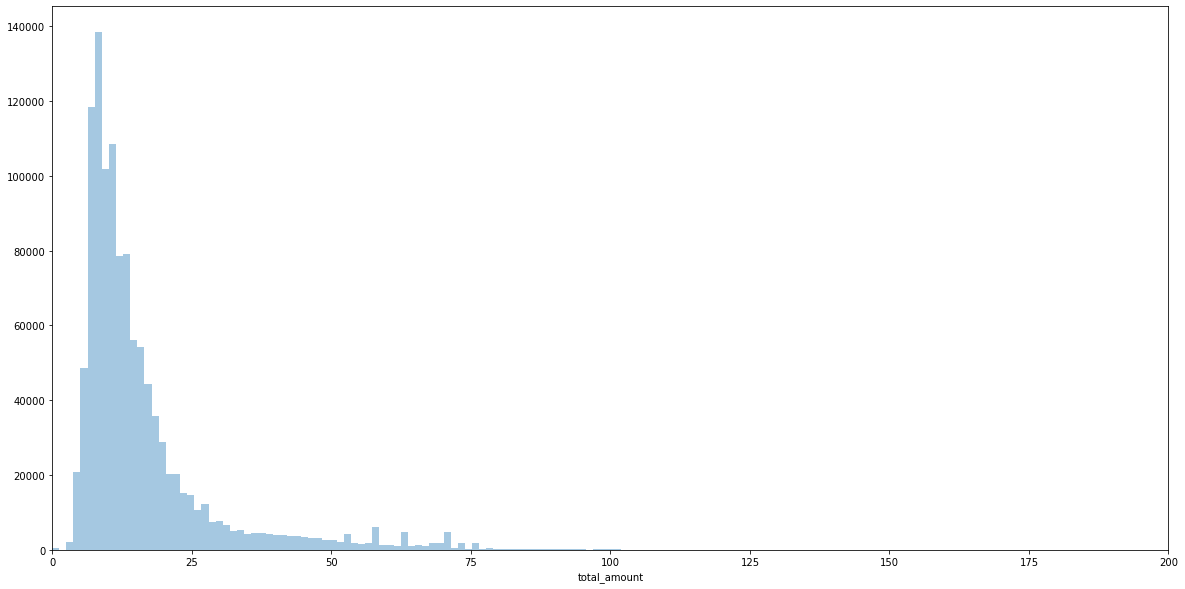

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df_train_raw['total_amount'], bins = 8000, kde = False)
plt.xlim(0,200)
plt.show()

In [55]:
df = df_raw.copy()
df_geom = df_geom_raw.copy()

In [56]:
# add column for total fare, not including tip
df['total_fare'] = df['fare_amount'] + df['tolls_amount']

# add column for trip duration in minutes
df['trip_duration_mins'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['trip_duration_mins'] = df['trip_duration_mins'].dt.total_seconds() / 60.0

# add columns for day and hour of week
df['PU_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['PU_hour_of_week'] = df['PU_day_of_week'] * 24 + df['tpep_pickup_datetime'].dt.hour

In [57]:
# add columns from geometry dataframe, including pickup and dropoff latitude and longitude
    
# calculate zone center by averaging lat/long over bounding polygon
df_geom['zone_center'] = df_geom['zone_geom'].apply(calculate_center)

# join zone_center to df_cleaned
df_geom['zone_id'] = df_geom['zone_id'].astype(str).astype(int)
df = pd.merge(df, df_geom, how = 'left', left_on = 'PULocationID', right_on = 'zone_id')
df = df.rename(columns={"zone_id": "PU_zone_ID", "zone_name": "PU_zone_name", "borough": "PU_zone_borough", "zone_geom": "PU_zone_geom", "zone_center": "PU_zone_center"})
df = pd.merge(df, df_geom, how = 'left', left_on = 'DOLocationID', right_on = 'zone_id')
df = df.rename(columns={"zone_id": "DO_zone_ID", "zone_name": "DO_zone_name", "borough": "DO_zone_borough", "zone_geom": "DO_zone_geom", "zone_center": "DO_zone_center"})

'''
# manipulations for haversine distance, which is not needed below
# remove rows with NA for PU or DO locations 
shape_init = df.shape
df = df[df['PU_zone_center'].notna() & df['DO_zone_center'].notna()]
df = df.reset_index()
shape_new = df.shape
num_rows_removed = shape_init[0] - shape_new[0]

# add column with geodesic/haversine - for our purposes, basically straightline - distance.
df['straightline_distance'] = df.apply(lambda row: haversine_distance(row), axis=1)
'''

"\n# remove rows with NA for PU or DO locations \nshape_init = df.shape\ndf = df[df['PU_zone_center'].notna() & df['DO_zone_center'].notna()]\ndf = df.reset_index()\nshape_new = df.shape\nnum_rows_removed = shape_init[0] - shape_new[0]\n\n# add column with geodesic/haversine - for our purposes, basically straightline - distance.\ndf['straightline_distance'] = df.apply(lambda row: haversine_distance(row), axis=1)\n"

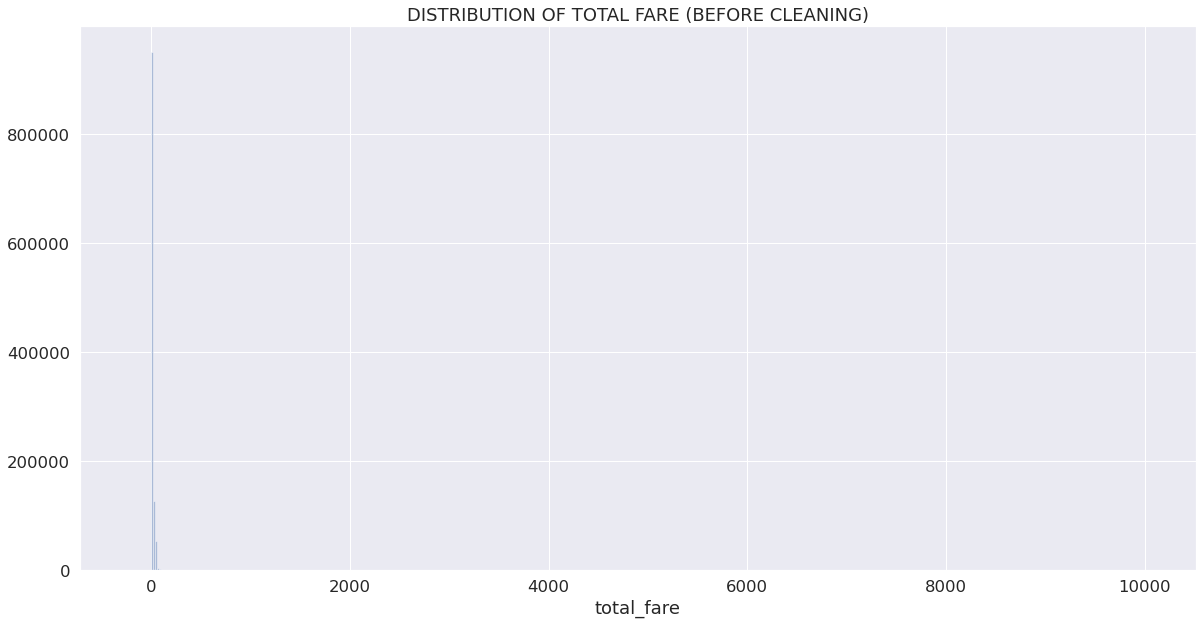

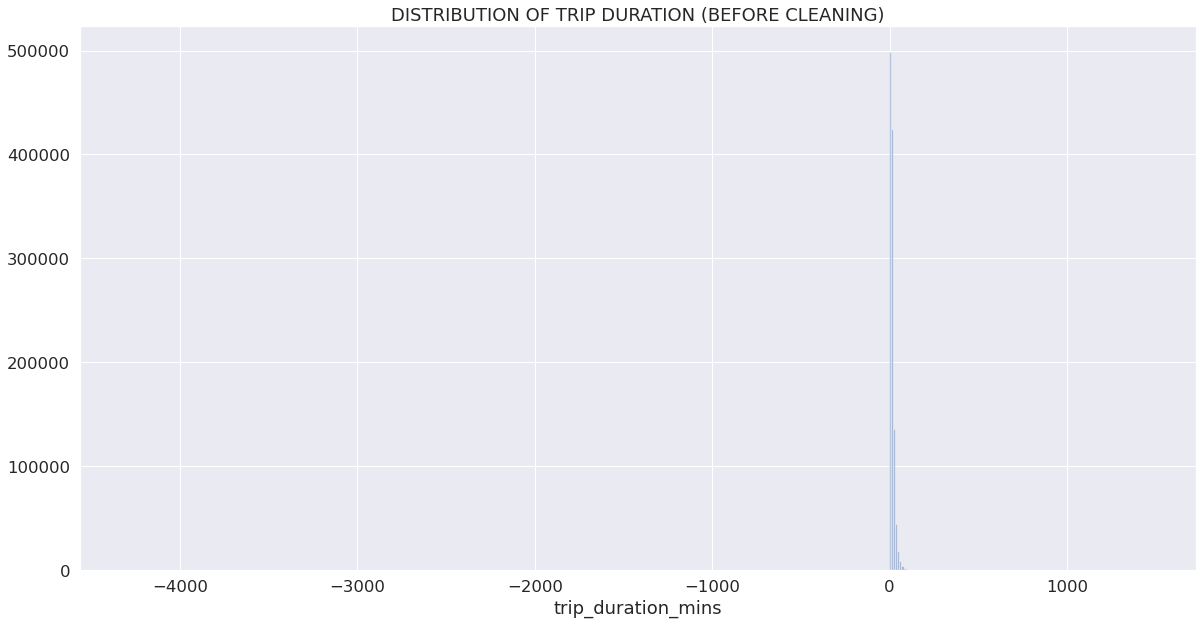

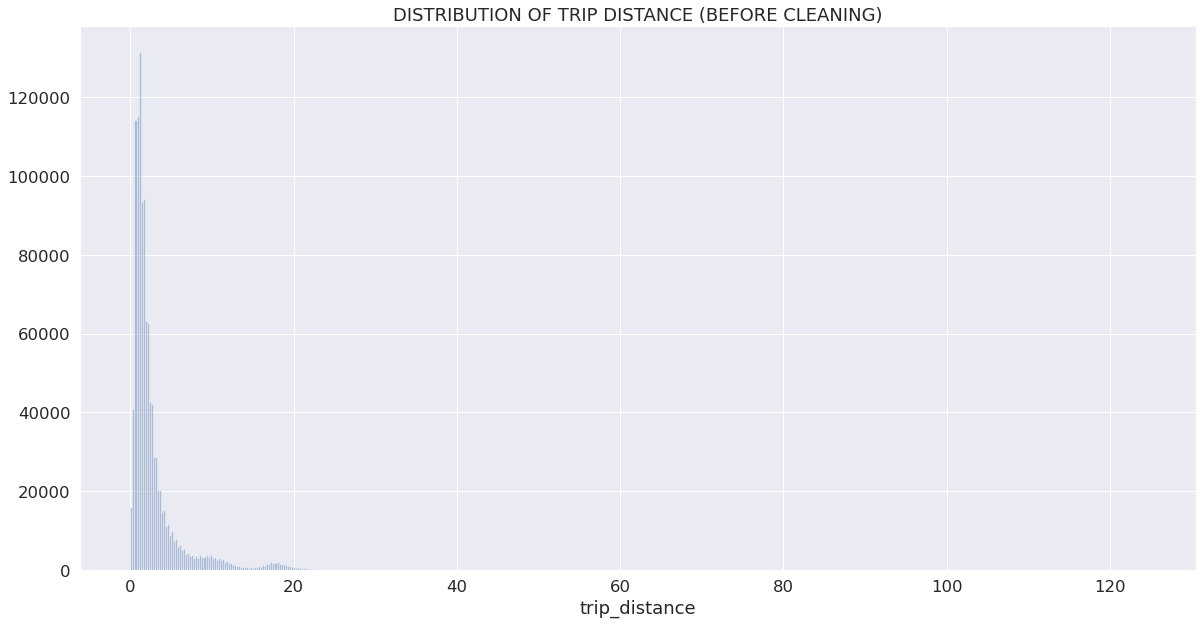

"\nfig, ax = plt.subplots(figsize=(20,10))\nax = sns.distplot(df['straightline_distance'], bins = 500, kde = False)\nplt.title('DISTRIBUTION OF STRAIGHTLINE TRIP DISTANCE (BEFORE CLEANING)')\nplt.show()\n"

In [58]:
# visualize data prior to cleaning
    
# distributions of total fare, duration, trip distance, straightline distance

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df['total_fare'], bins = 500, kde = False)
plt.title('DISTRIBUTION OF TOTAL FARE (BEFORE CLEANING)')
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df['trip_duration_mins'], bins = 500, kde = False)
plt.title('DISTRIBUTION OF TRIP DURATION (BEFORE CLEANING)')
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df['trip_distance'], bins = 500, kde = False)
plt.title('DISTRIBUTION OF TRIP DISTANCE (BEFORE CLEANING)')
plt.show()
'''
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df['straightline_distance'], bins = 500, kde = False)
plt.title('DISTRIBUTION OF STRAIGHTLINE TRIP DISTANCE (BEFORE CLEANING)')
plt.show()
'''

In [59]:
exclude_nonstandard_ratecode = df['RatecodeID'] == 1

exclude_small_distances = df['trip_distance'] > .25
exclude_large_distances = df['trip_distance'] < 50
exclude_small_fares = df['total_fare'] >= 3
exclude_large_fares = df['total_fare'] <= 120
exclude_small_durations = df['trip_duration_mins'] > 1
exclude_large_durations = df['trip_duration_mins'] < 120

In [60]:
df = df[exclude_small_distances & exclude_large_distances & exclude_small_fares & exclude_large_fares & exclude_nonstandard_ratecode & exclude_small_durations & exclude_large_durations]

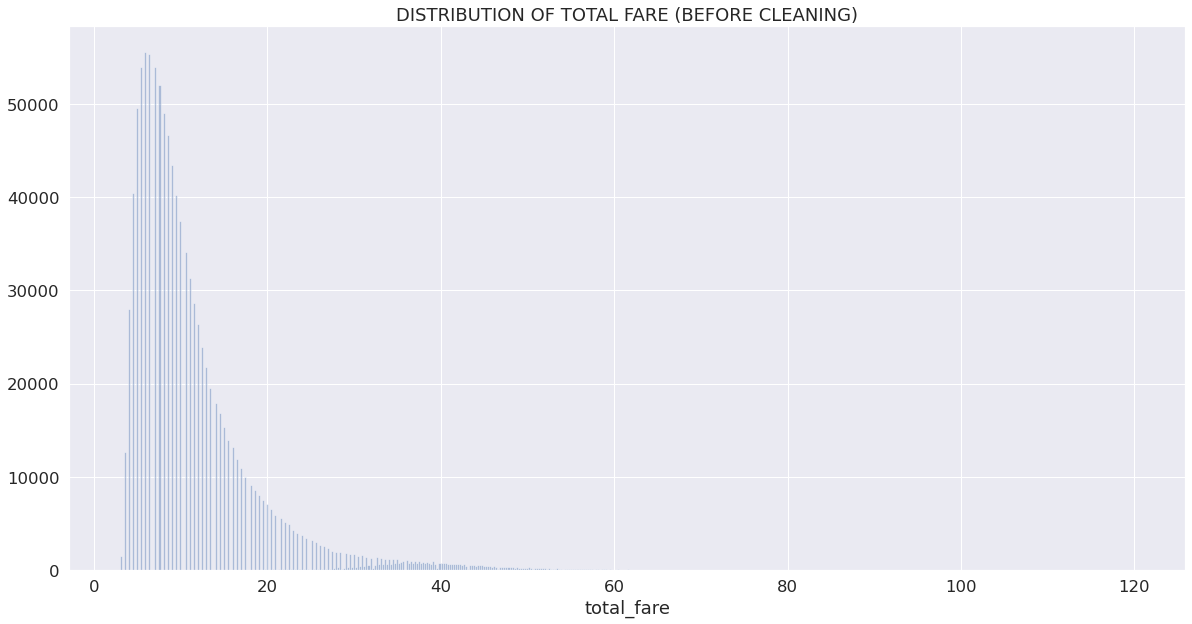

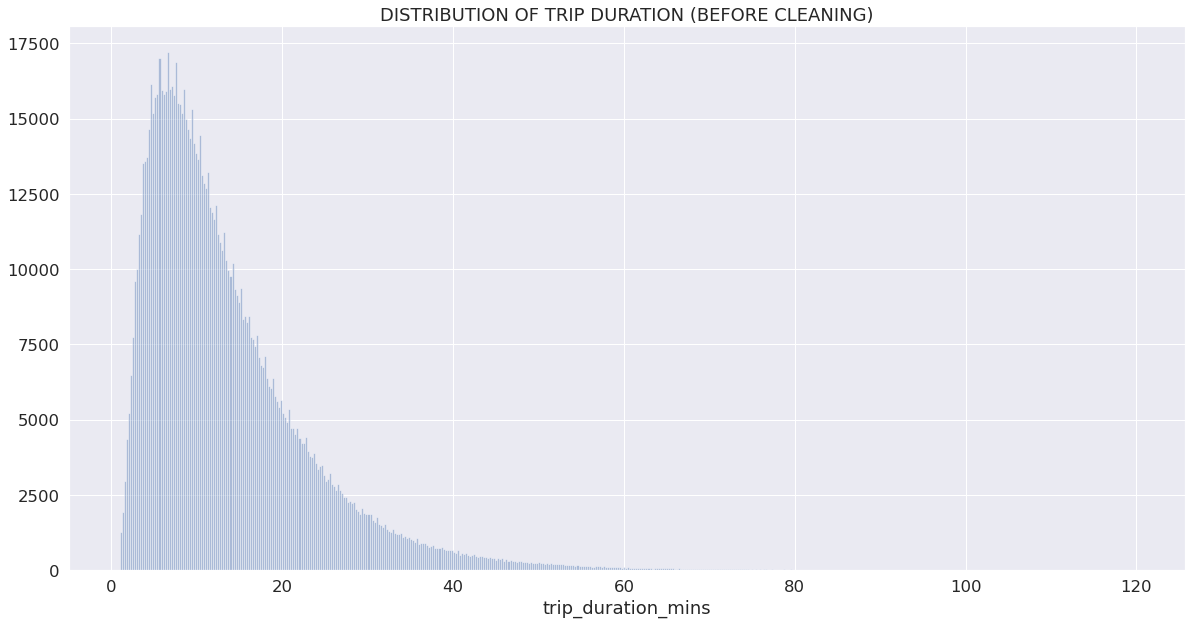

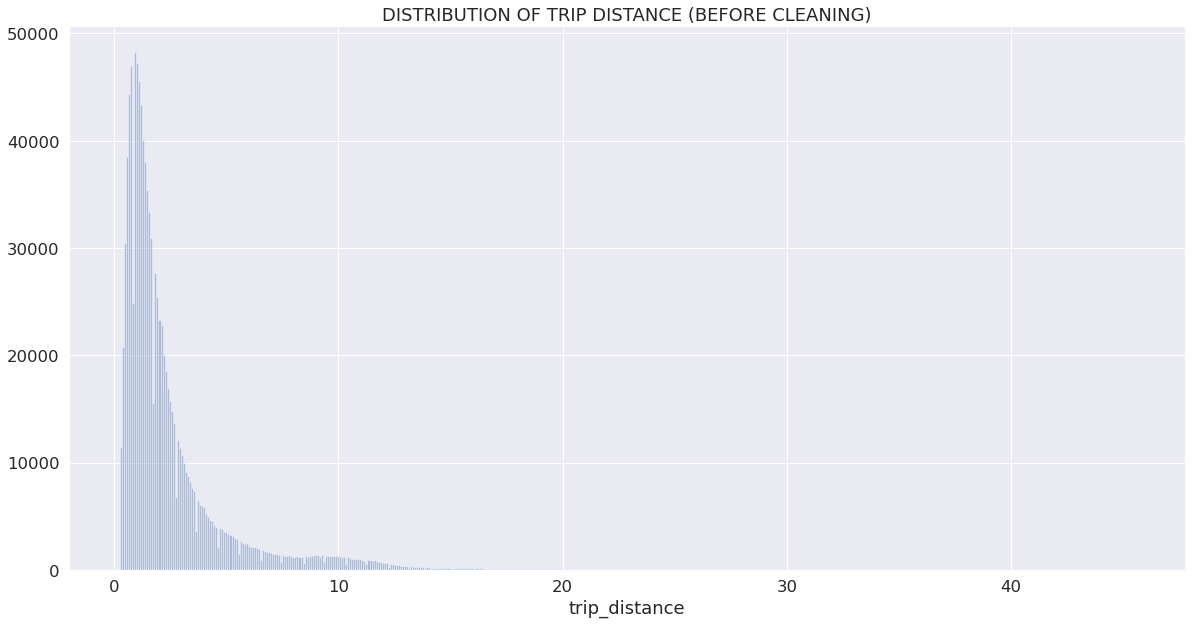

"\nfig, ax = plt.subplots(figsize=(20,10))\nax = sns.distplot(df['straightline_distance'], bins = 500, kde = False)\nplt.title('DISTRIBUTION OF STRAIGHTLINE TRIP DISTANCE (BEFORE CLEANING)')\nplt.show()\n"

In [62]:
# visualize after cleaning
    
# distributions of total fare, duration, trip distance, straightline distance

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df['total_fare'], bins = 500, kde = False)
plt.title('DISTRIBUTION OF TOTAL FARE (BEFORE CLEANING)')
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df['trip_duration_mins'], bins = 500, kde = False)
plt.title('DISTRIBUTION OF TRIP DURATION (BEFORE CLEANING)')
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df['trip_distance'], bins = 500, kde = False)
plt.title('DISTRIBUTION OF TRIP DISTANCE (BEFORE CLEANING)')
plt.show()
'''
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df['straightline_distance'], bins = 500, kde = False)
plt.title('DISTRIBUTION OF STRAIGHTLINE TRIP DISTANCE (BEFORE CLEANING)')
plt.show()
'''

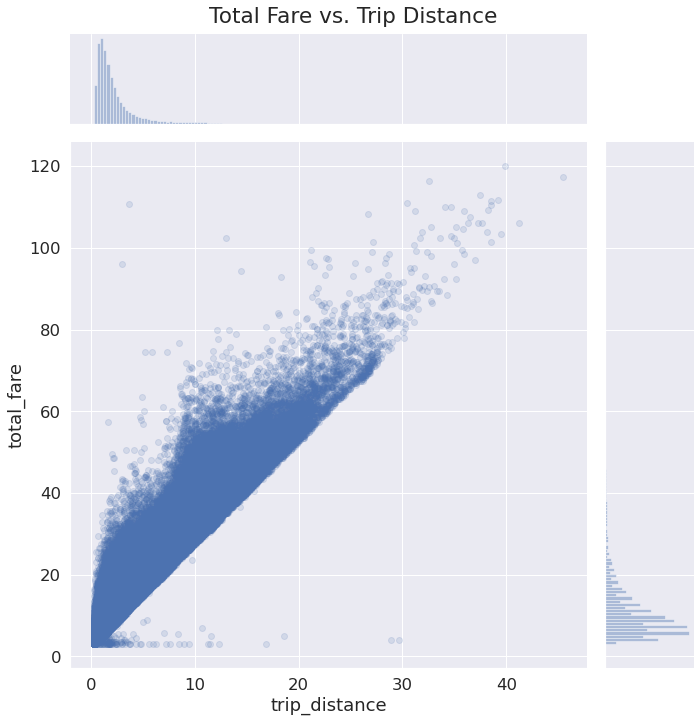

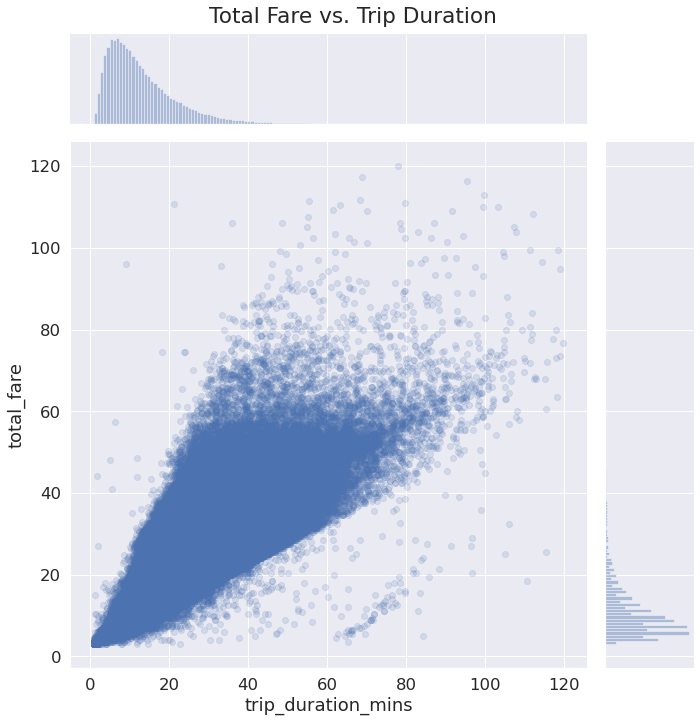

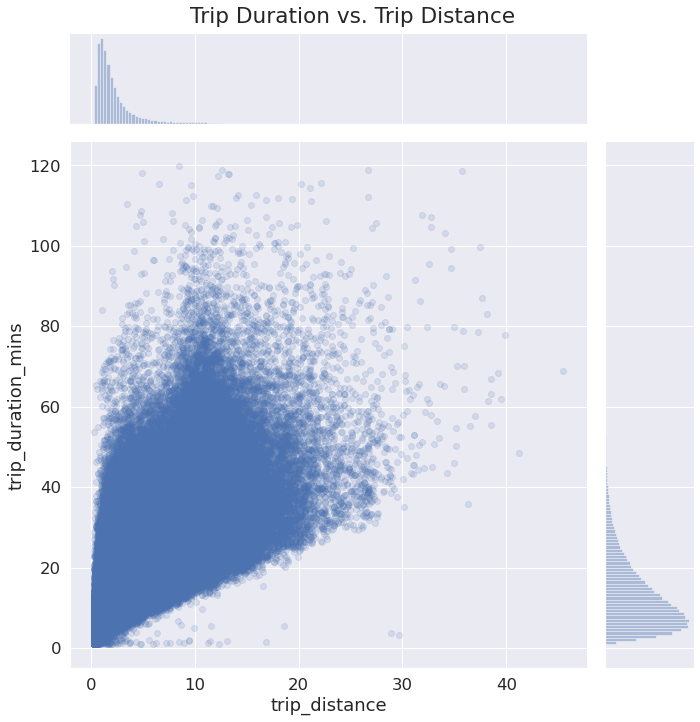

In [63]:
# joint plots of of duration, distance, fare 

sns.set(font_scale=1.5)
g = sns.jointplot(df['trip_distance'], df['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=150))
g.fig.suptitle('Total Fare vs. Trip Distance', y=1.01)
plt.show()

g = sns.jointplot(df['trip_duration_mins'], df['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=150))
g.fig.suptitle('Total Fare vs. Trip Duration', y=1.01)
plt.show()

g = sns.jointplot(df['trip_distance'], df['trip_duration_mins'], height = 10, alpha = .15, marginal_kws = dict(bins=150))
g.fig.suptitle('Trip Duration vs. Trip Distance', y=1.01)
plt.show()

Remove outliers in terms of slope. Only exclude small slopes for ratios of fare to distance and duration to distance since large slopes for these may result from sitting still in traffic for long periods - i.e., large slopes don't appear necessarily to be outliers.  

In [75]:
exclude_small_fare_distance_ratio = df['total_fare']/df['trip_distance'] > 2.0
exclude_small_fare_duration_ratio = df['total_fare']/df['trip_duration_mins'] > .5
exclude_large_fare_duration_ratio = df['total_fare']/df['trip_duration_mins'] < 3.0
exclude_small_duration_distance_ratio = df['trip_duration_mins']/df['trip_distance'] > 1.0

In [76]:
df = df[exclude_small_fare_distance_ratio & exclude_small_fare_duration_ratio & exclude_large_fare_duration_ratio & exclude_small_duration_distance_ratio]

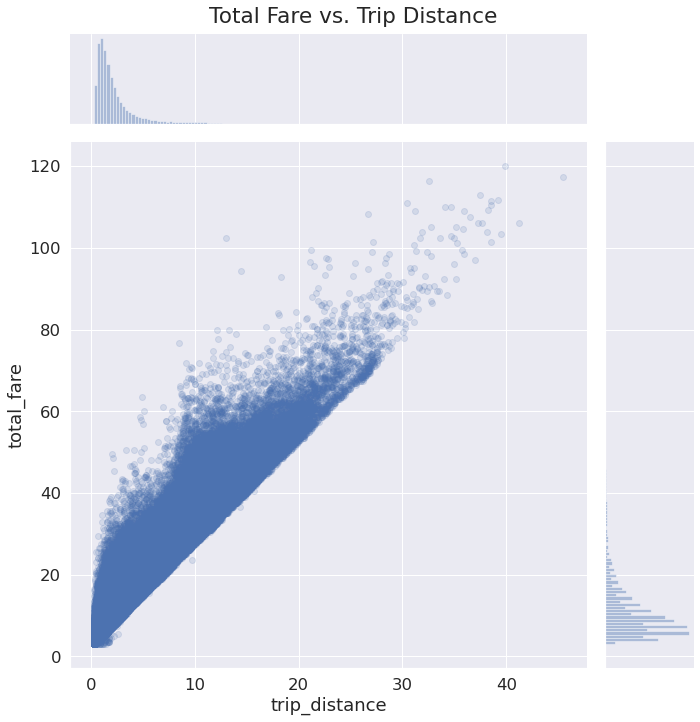

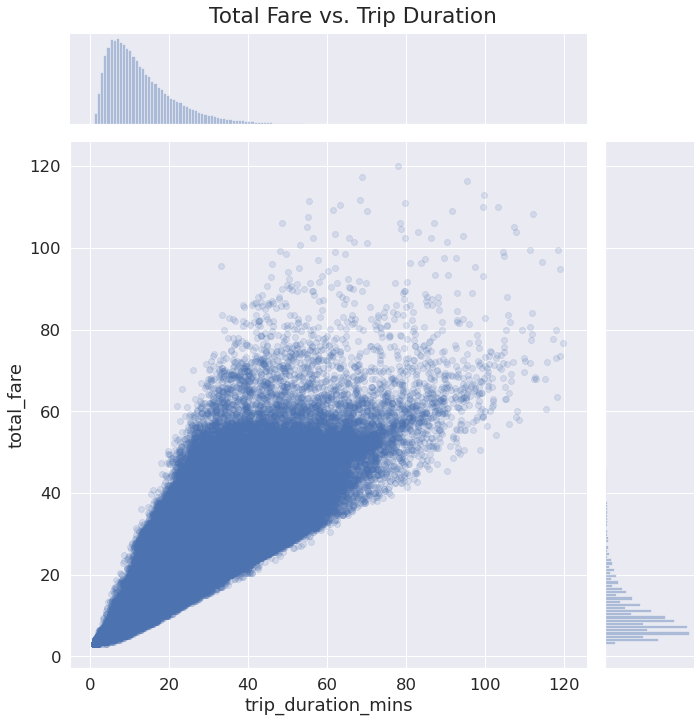

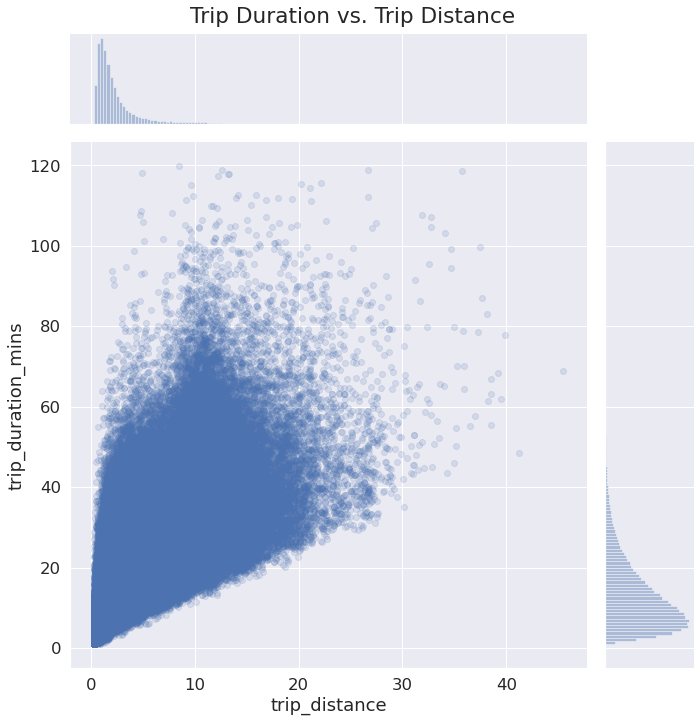

In [77]:
# joint plots after removal of outliers

sns.set(font_scale=1.5)
g = sns.jointplot(df['trip_distance'], df['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=150))
g.fig.suptitle('Total Fare vs. Trip Distance', y=1.01)
plt.show()

g = sns.jointplot(df['trip_duration_mins'], df['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=150))
g.fig.suptitle('Total Fare vs. Trip Duration', y=1.01)
plt.show()

g = sns.jointplot(df['trip_distance'], df['trip_duration_mins'], height = 10, alpha = .15, marginal_kws = dict(bins=150))
g.fig.suptitle('Trip Duration vs. Trip Distance', y=1.01)
plt.show()

PLOTTING AVG TOTAL FARE VS. TRIP DISTANCE ...


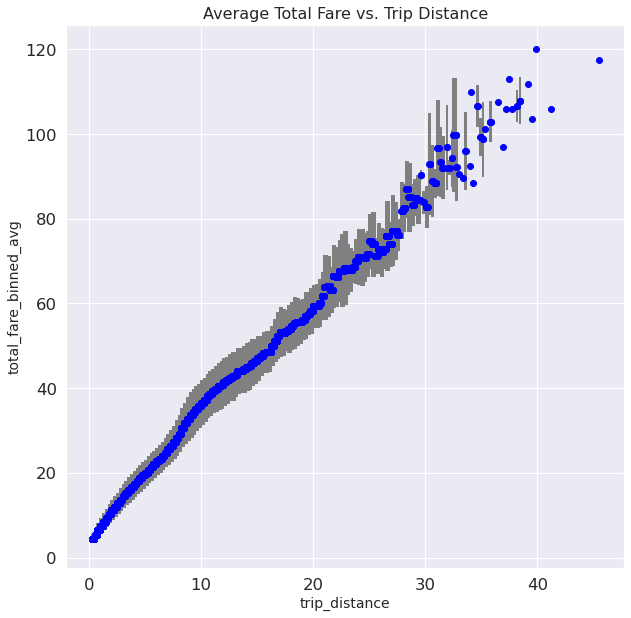

PLOTTING BEST FIT LINE FOR TOTAL FARE VS TRIP DISTANCE ...


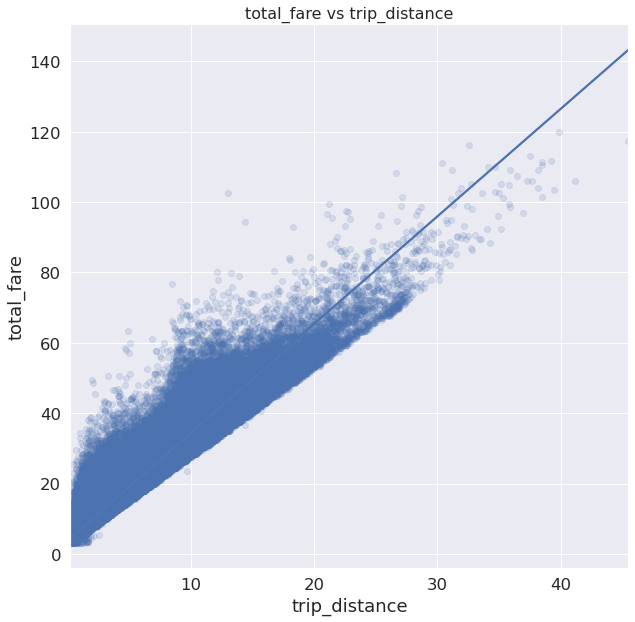

In [78]:
# visualize average total fare vs total trip distance
    
# bin in .25 mile intervals of distance
distance_bins = [.25* i for i in range(int(50/.25))]
df['trip_distance_binned'] = pd.cut(df['trip_distance'], distance_bins)
# compute mean and std of total fare over trip distance bins, add them as new columns
df_temp = df[['trip_distance_binned', 'total_fare']].groupby('trip_distance_binned').agg({'total_fare': ['mean', 'std']})
mean_std_dict = df_temp['total_fare'][['mean', 'std']].to_dict()
df['total_fare_binned_avg'] = df['trip_distance_binned'].map(mean_std_dict['mean'])
df['total_fare_binned_std'] = df['trip_distance_binned'].map(mean_std_dict['std'])

print('PLOTTING AVG TOTAL FARE VS. TRIP DISTANCE ...')
fig, ax = plt.subplots(figsize=(10,10))
plt.errorbar(df['trip_distance'], df['total_fare_binned_avg'], yerr = df['total_fare_binned_std'], fmt='o', color='blue',
             ecolor='gray', elinewidth=2)
plt.xlabel('trip_distance', fontsize=14)
plt.ylabel('total_fare_binned_avg', fontsize=14)
plt.title('Average Total Fare vs. Trip Distance', fontsize=16)
plt.show()

print('PLOTTING BEST FIT LINE FOR TOTAL FARE VS TRIP DISTANCE ...')
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.regplot(x = df['trip_distance'], y = df['total_fare'], scatter_kws={'alpha':0.15})
plt.title('total_fare vs trip_distance', fontsize = 16)
plt.show()

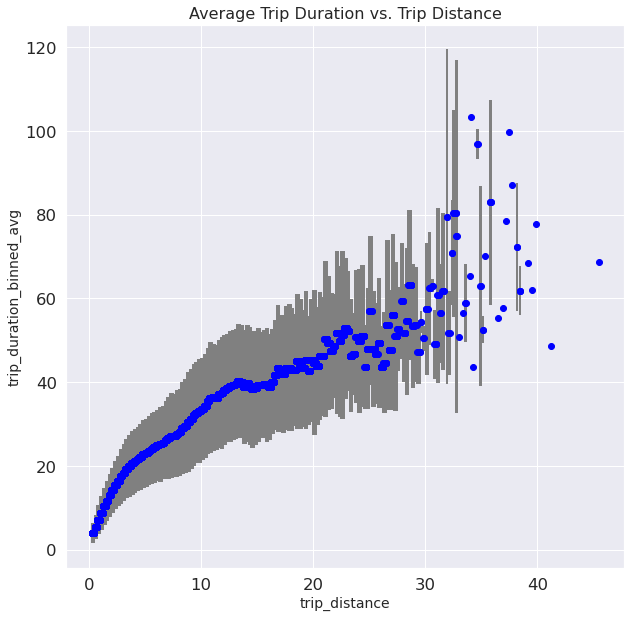

In [ ]:
# visualize average trip duration vs. trip distance 
    
# bin in .25 mile intervals of distance
distance_bins = [.25* i for i in range(int(50/.25))]
df['trip_distance_binned'] = pd.cut(df['trip_distance'], distance_bins)
# compute mean and std of total fare over trip distance bins, add them as new columns
df_temp = df[['trip_distance_binned', 'trip_duration_mins']].groupby('trip_distance_binned').agg({'trip_duration_mins': ['mean', 'std']})
mean_std_dict = df_temp['trip_duration_mins'][['mean', 'std']].to_dict()

df['trip_duration_binned_avg'] = df['trip_distance_binned'].map(mean_std_dict['mean'])
df['trip_duration_binned_std'] = df['trip_distance_binned'].map(mean_std_dict['std'])

fig, ax = plt.subplots(figsize=(10,10))
plt.errorbar(df['trip_distance'], df['trip_duration_binned_avg'], yerr = df['trip_duration_binned_std'], fmt='o', color='blue',
             ecolor='gray', elinewidth=2)
plt.xlabel('trip_distance', fontsize=14)
plt.ylabel('trip_duration_binned_avg', fontsize=14)
plt.title('Average Trip Duration vs. Trip Distance', fontsize=16)
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.regplot(x = df['trip_distance'], y = df['trip_duration_mins'], scatter_kws={'alpha':0.15})
plt.title('total_fare vs trip_distance', fontsize = 16)
plt.show()




In [81]:
def preprocess(df, df_geom):
    
    # add columns for total fare, distance, and duration
    
    # calculate number of rows prior to cleaning for later comparison
    num_rows_init = df.shape[0]
    
    # add column for total fare, not including tip
    df['total_fare'] = df['fare_amount'] + df['tolls_amount']
    
    # add column for trip duration in minutes
    df['trip_duration_mins'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['trip_duration_mins'] = df['trip_duration_mins'].dt.total_seconds() / 60.0
    
    # add columns for day and hour of week
    df['PU_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['PU_hour_of_week'] = df['PU_day_of_week'] * 24 + df['tpep_pickup_datetime'].dt.hour
    
    
    
    # add columns from geometry dataframe, including pickup and dropoff latitude and longitude
    
    # calculate zone center by averaging lat/long over bounding polygon
    df_geom['zone_center'] = df_geom['zone_geom'].apply(calculate_center)
    
    # join zone_center to df_cleaned
    df_geom['zone_id'] = df_geom['zone_id'].astype(str).astype(int)
    df = pd.merge(df, df_geom, how = 'left', left_on = 'PULocationID', right_on = 'zone_id')
    df = df.rename(columns={"zone_id": "PU_zone_ID", "zone_name": "PU_zone_name", "borough": "PU_zone_borough", "zone_geom": "PU_zone_geom", "zone_center": "PU_zone_center"})
    df = pd.merge(df, df_geom, how = 'left', left_on = 'DOLocationID', right_on = 'zone_id')
    df = df.rename(columns={"zone_id": "DO_zone_ID", "zone_name": "DO_zone_name", "borough": "DO_zone_borough", "zone_geom": "DO_zone_geom", "zone_center": "DO_zone_center"})

    # remove rows with NA for PU or DO locations 
    shape_init = df.shape
    df = df[df['PU_zone_center'].notna() & df['DO_zone_center'].notna()]
    df = df.reset_index()
    shape_new = df.shape
    num_rows_removed = shape_init[0] - shape_new[0]
    
    # add column with geodesic/haversine - for our purposes, basically straightline - distance.
    df['straightline_distance'] = df.apply(lambda row: haversine_distance(row), axis=1)
    
    
    
    # visualize data prior to cleaning
    
    # distributions of total fare, duration, trip distance, straightline distance
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.distplot(df['total_fare'], bins = 500, kde = False)
    plt.title('DISTRIBUTION OF TOTAL FARE (BEFORE CLEANING)')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.distplot(df['trip_duration_mins'], bins = 500, kde = False)
    plt.title('DISTRIBUTION OF TRIP DURATION (BEFORE CLEANING)')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.distplot(df['trip_distance'], bins = 500, kde = False)
    plt.title('DISTRIBUTION OF TRIP DISTANCE (BEFORE CLEANING)')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.distplot(df['straightline_distance'], bins = 500, kde = False)
    plt.title('DISTRIBUTION OF STRAIGHTLINE TRIP DISTANCE (BEFORE CLEANING)')
    plt.show()
    

    
    
    # joint plots of of duration, distance, fare
    
    sns.set(font_scale=1.5)
    sns.jointplot(df['trip_distance'], df['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=150))
    plt.title('TOTAL FARE VS. TRIP DISTANCE (BEFORE CLEANING)')
    plt.show()
    
    sns.set(font_scale=1.5)
    sns.jointplot(df['total_duration_mins'], df['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=150))
    plt.title('TOTAL DURATION VS. TRIP DISTANCE (BEFORE CLEANING)')
    plt.show()
    
    sns.set(font_scale=1.5)
    sns.jointplot(df['total_duration_mins'], df['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=150))
    plt.show()
    
    
    '''
    # clean data: remove rows that are unwanted, faulty, or outliers.
    
    #remove distances and fares that are excessively small, and focus on prediction for standard ratecode, rather
    #than special rates (e.g. fixed rates to JFK, EWR, etc.). also exclude trips that are outliers with respect to 
    #ratio of total fare to trip distance.
    
    exclude_small_distances = df['trip_distance'] > .25
    exclude_large_distances = df['trip_distance'] < 50
    exclude_small_fares = (df['total_fare'] >= 3)
    exclude_large_fares = (df['total_fare'] <= 120)
    exclude_nonstandard_ratecode = (df['RatecodeID'] == 1)
    exclude_small_faretodistance_ratio = (df['total_fare']/df['trip_distance'] > 2)

    df_cleaned = df[exclude_small_distances & exclude_large_distances & exclude_small_fares & exclude_large_fares & exclude_nonstandard_ratecode & exclude_small_faretodistance_ratio]
    
    print('PLOTTING TOTAL FARE VS. TRIP DISTANCE AFTER REMOVAL OF EXTREME FARES AND DISTANCES ...')
    sns.jointplot(df_cleaned['trip_distance'], df_cleaned['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=100))
    plt.show()     
        
    # visualize average total fare vs total trip distance
    
    # bin in .25 mile intervals of distance
    distance_bins = [.25* i for i in range(int(50/.25))]
    df_cleaned['trip_distance_binned'] = pd.cut(df_cleaned['trip_distance'], distance_bins)
    # compute mean and std of total fare over trip distance bins, add them as new columns
    df_temp = df_cleaned[['trip_distance_binned', 'total_fare']].groupby('trip_distance_binned').agg({'total_fare': ['mean', 'std']})
    mean_std_dict = df_temp['total_fare'][['mean', 'std']].to_dict()
    df_cleaned['total_fare_binned_avg'] = df_cleaned['trip_distance_binned'].map(mean_std_dict['mean'])
    df_cleaned['total_fare_binned_std'] = df_cleaned['trip_distance_binned'].map(mean_std_dict['std'])
    
    print('PLOTTING AVG TOTAL FARE VS. TRIP DISTANCE ...')
    fig, ax = plt.subplots(figsize=(10,10))
    plt.errorbar(df_cleaned['trip_distance'], df_cleaned['total_fare_binned_avg'], yerr = df_cleaned['total_fare_binned_std'], fmt='o', color='blue',
                 ecolor='gray', elinewidth=2)
    plt.xlabel('trip_distance', fontsize=14)
    plt.ylabel('total_fare_binned_avg', fontsize=14)
    plt.title('Average Total Fare vs. Trip Distance', fontsize=16)
    plt.show()
    
    print('PLOTTING BEST FIT LINE FOR TOTAL FARE VS TRIP DISTANCE ...')
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    sns.regplot(x = df_cleaned['trip_distance'], y = df_cleaned['total_fare'], scatter_kws={'alpha':0.15})
    plt.title('total_fare vs trip_distance', fontsize = 16)
    plt.show()

    
    
    # add columns with average and std of total fare over binned trip distance
    
    # bin in .25 mile intervals of distance
    distance_bins = [.25* i for i in range(int(50/.25))]
    df_cleaned['trip_distance_binned'] = pd.cut(df_cleaned['trip_distance'], distance_bins)

    # compute mean and std of total fare over trip distance bins, add them as new columns
    df_temp = df_cleaned[['trip_distance_binned', 'total_fare']].groupby('trip_distance_binned').agg({'total_fare': ['mean', 'std']})
    mean_std_dict = df_temp['total_fare'][['mean', 'std']].to_dict()
    df_cleaned['total_fare_binned_avg'] = df_cleaned['trip_distance_binned'].map(mean_std_dict['mean'])
    df_cleaned['total_fare_binned_std'] = df_cleaned['trip_distance_binned'].map(mean_std_dict['std'])

    
    
    
    
    
    # remove rows with NA for PU or DO locations 
    
    shape_init = df_cleaned.shape
    df_cleaned = df_cleaned[df_cleaned['PU_zone_center'].notna() & df_cleaned['DO_zone_center'].notna()]
    df_cleaned = df_cleaned.reset_index()
    shape_new = df_cleaned.shape
    num_rows_removed = shape_init[0] - shape_new[0]
    print('num_rows_removed for na values in PU_zone_center and DO_zone_center columns: ' +str(num_rows_removed))

    
    
    
    
    print('PLOTTING HISTOGRAM OF STRAIGHT LINE DISTANCES ...')
    df_cleaned['PU_DO_straightline_distance'].hist(bins=100, figsize=(10,10))
    plt.show()
    
    print('PLOTTING TOTAL FARE VS. STRAIGHT LINE DISTANCE ...')
    sns.jointplot(df_cleaned['PU_DO_straightline_distance'], df_cleaned['total_fare'],  height = 10, alpha = .15, marginal_kws = dict(bins=100))
    plt.show()
    
    
    
    
    
    
     # bin in .25 mile intervals of distance
    distance_bins = [.25* i for i in range(int(50/.25))]
    df_cleaned['PU_DO_straightline_distance_binned'] = pd.cut(df_cleaned['PU_DO_straightline_distance'], distance_bins)
    # compute mean and std of total fare over trip distance bins, add them as new columns
    df_temp = df_cleaned[['PU_DO_straightline_distance_binned', 'total_fare']].groupby('PU_DO_straightline_distance_binned').agg({'total_fare': ['mean', 'std']})
    mean_std_dict = df_temp['total_fare'][['mean', 'std']].to_dict()
    df_cleaned['PU_DO_straightline_distance_binned_avg'] = df_cleaned['PU_DO_straightline_distance_binned'].map(mean_std_dict['mean'])
    df_cleaned['PU_DO_straightline_distance_binned_std'] = df_cleaned['PU_DO_straightline_distance_binned'].map(mean_std_dict['std'])
    
    print('PLOTTING AVG TOTAL FARE VS. STRAIGHTLINE TRIP DISTANCE ...')
    fig, ax = plt.subplots(figsize=(10,10))
    plt.errorbar(df_cleaned['PU_DO_straightline_distance'], df_cleaned['PU_DO_straightline_distance_binned_avg'], yerr = df_cleaned['PU_DO_straightline_distance_binned_std'], fmt='o', color='blue',
                 ecolor='gray', elinewidth=2)
    plt.xlabel('PU_DO_straightline_distance', fontsize=14)
    plt.ylabel('PU_DO_straightline_distance_binned_avg', fontsize=14)
    plt.title('Average Total Fare vs. Straightline Trip Distance', fontsize=16)
    plt.show()
    
    
    
    
    
    
    
    
    print('PLOTTING BEST FIT LINE FOR TOTAL FARE VS STRAIGHT LINE DISTANCE ...')
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    sns.regplot(x = df_cleaned['PU_DO_straightline_distance'], y = df_cleaned['total_fare'], scatter_kws={'alpha':0.15})
    plt.title('total_fare vs straightline_distance', fontsize = 16)
    plt.show()
    
    num_rows_final = df_cleaned.shape[0]
    
    print('')
    print('TOTAL NUMBER OF ROWS REMOVED: ' + str(num_rows_init - num_rows_final))
    
    return df_cleaned
    '''

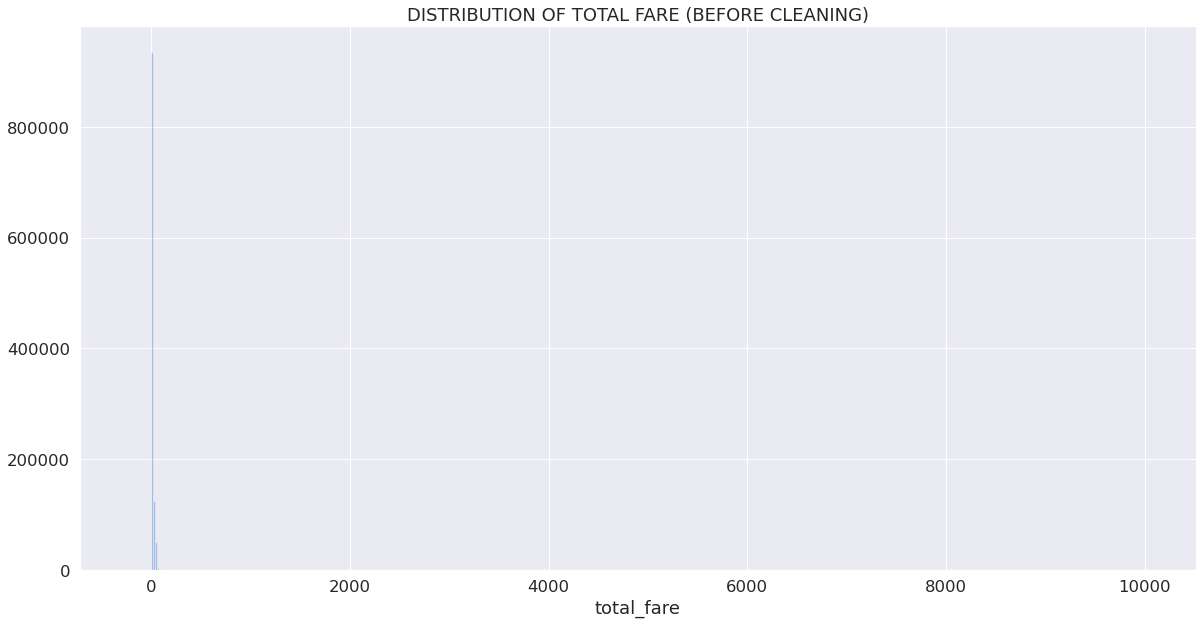

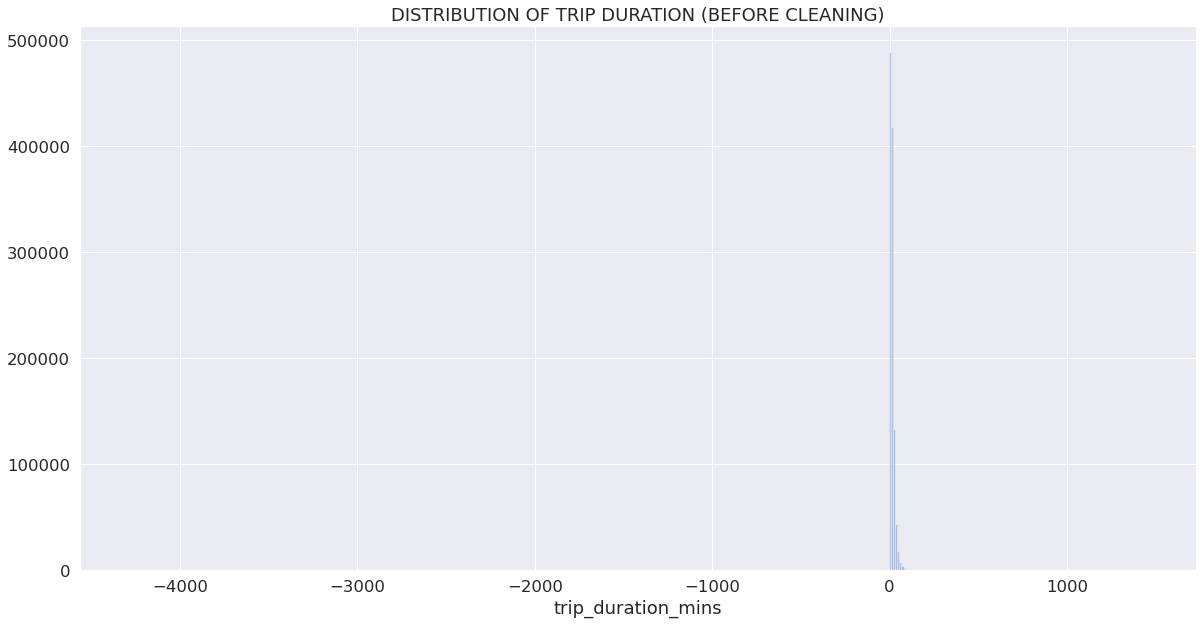

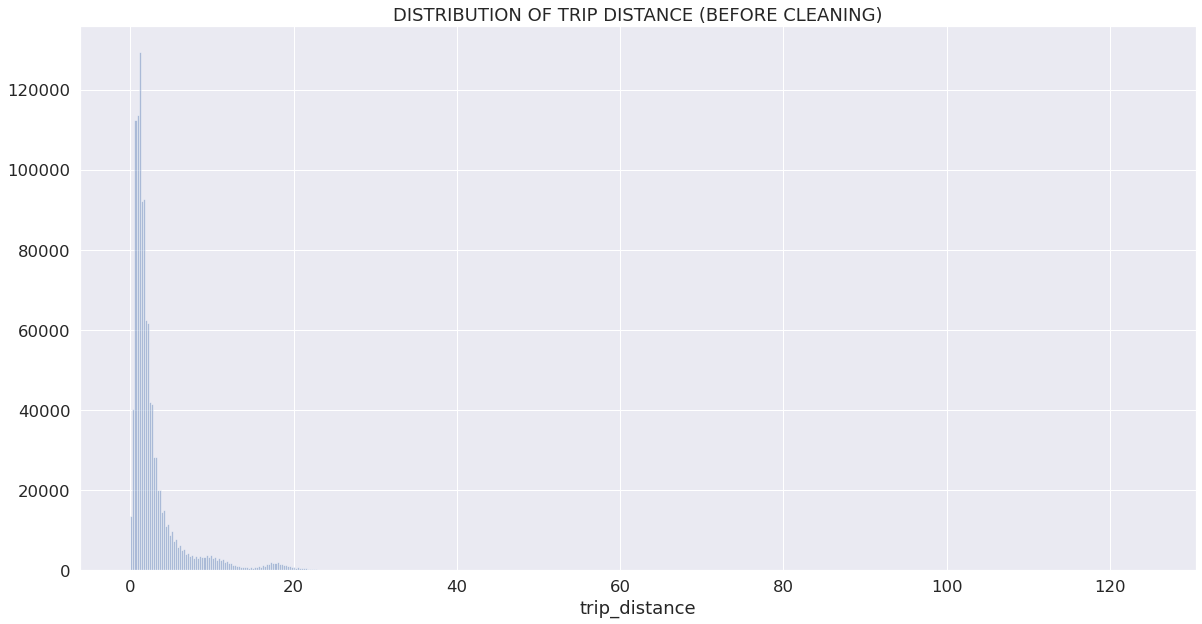

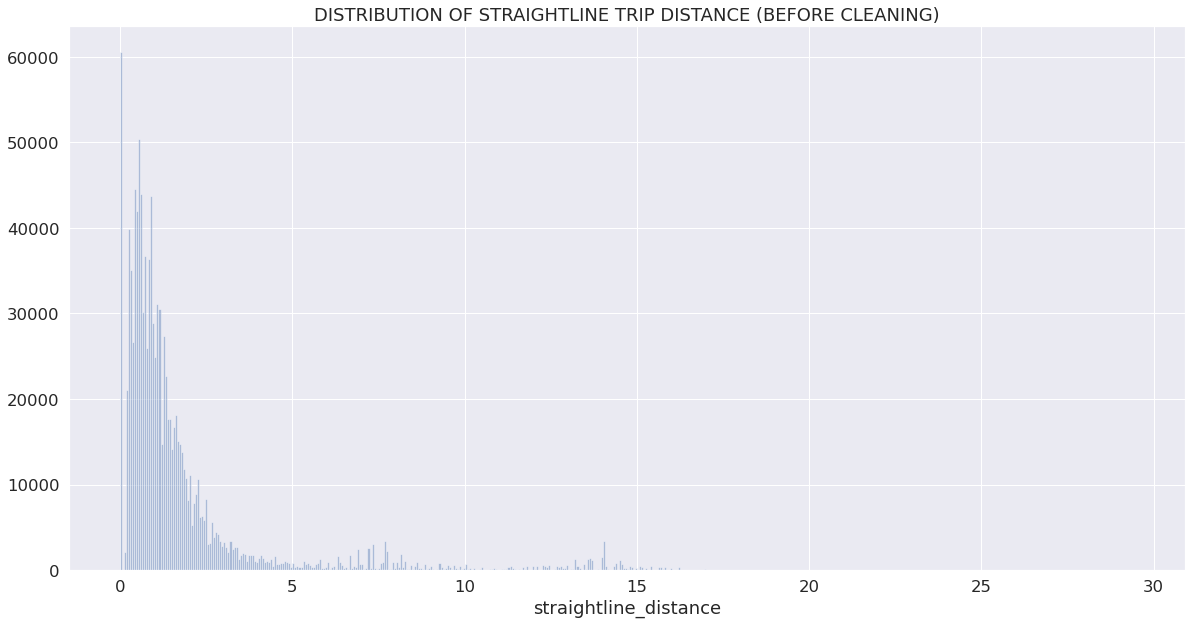

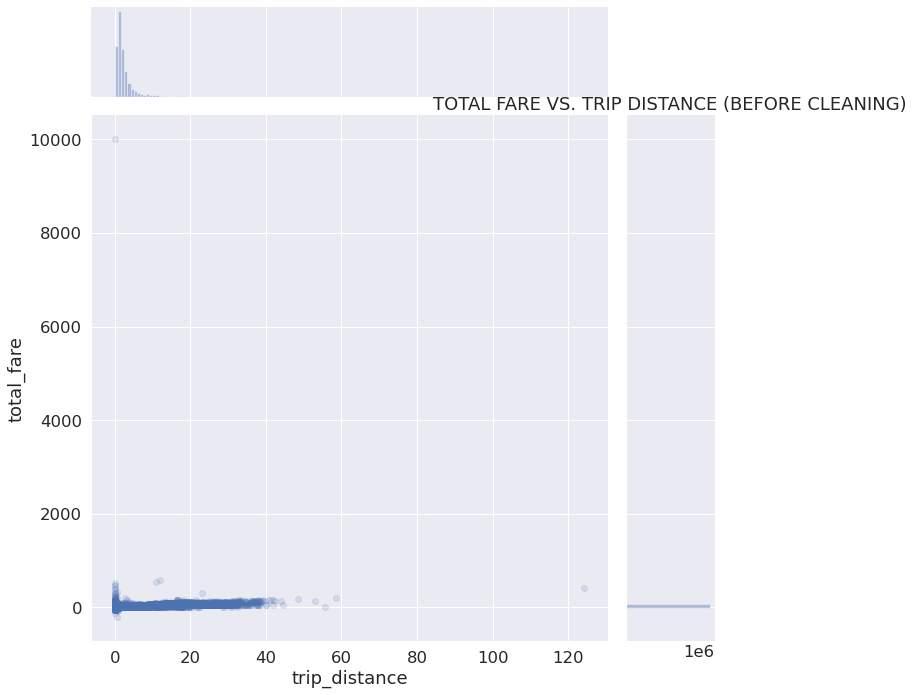

PLOTTING TOTAL DURATION VS. TRIP DISTANCE PRIOR TO CLEANING ...


KeyError: 'total_duration_mins'

In [82]:
df_train = preprocess(df_train_raw, df_geom_raw)

In [16]:
df_train.head()

index  VendorID      tpep_pickup_datetime     tpep_dropoff_datetime  \
0      0         2 2017-05-01 07:09:22+00:00 2017-05-01 07:18:07+00:00   
1      1         2 2017-05-01 10:19:40+00:00 2017-05-01 10:35:33+00:00   
2      2         2 2017-05-01 14:25:16+00:00 2017-05-01 14:37:20+00:00   
3      3         1 2017-05-01 16:13:59+00:00 2017-05-01 16:53:58+00:00   
4      4         2 2017-01-25 09:16:29+00:00 2017-01-25 09:29:14+00:00   

   passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0                1           1.39           1               False   
1                6           1.79           1               False   
2                6           1.35           1               False   
3                1           5.00           1               False   
4                1           1.62           1               False   

   PULocationID  DOLocationID  ...                           PU_zone_center  \
0           140           162  ...   (-73.9557192058001, 40.76390753050858)   
1           162           236  ...   (-73.97261531167338, 40.7565299845101)   
2           236           239  ...  (-73.9571287107499, 40.780276118538374)   
3           161            13  ...  (-73.97733755281567, 40.75776913971043)   
4           186           163  ...  (-73.99198045716656, 40.74861054308323)   

   DO_zone_ID           DO_zone_name  DO_zone_borough  \
0       162.0           Midtown East        Manhattan   
1       236.0  Upper East Side North        Manhattan   
2       239.0  Upper West Side South        Manhattan   
3        13.0      Battery Park City        Manhattan   
4       163.0          Midtown North        Manhattan   

                                        DO_zone_geom  \
0  POLYGON((-73.970759194 40.7558248509999, -73.9...   
1  POLYGON((-73.9572940999999 40.7742835549999, -...   
2  POLYGON((-73.9763914919999 40.7882667469999, -...   
3  POLYGON((-74.012554689 40.719069863, -74.01270...   
4  POLYGON((-73.9814146949998 40.7677778729999, -...   

                            DO_zone_center  PU_DO_straightline_distance  \
0   (-73.97261531167338, 40.7565299845101)                     1.176239   
1  (-73.9571287107499, 40.780276118538374)                     1.162406   
2  (-73.98318459098333, 40.78479699627972)                     1.802919   
3  (-74.01732606477353, 40.70941905728343)                     2.913303   
4   (-73.9787581414772, 40.76555919693171)                     0.969320   

   PU_DO_straightline_distance_binned  PU_DO_straightline_distance_binned_avg  \
0                         (1.0, 1.25]                                9.832579   
1                         (1.0, 1.25]                                9.832579   
2                         (1.75, 2.0]                               13.673239   
3                         (2.75, 3.0]                               18.599128   
4                         (0.75, 1.0]                                9.269385   

   PU_DO_straightline_distance_binned_std  
0                                4.260202  
1                                4.260202  
2                                5.445900  
3                                7.046017  
4                                4.048174  

[5 rows x 37 columns]

In [17]:
df_train.describe()

index      VendorID  passenger_count  trip_distance  RatecodeID  \
count  1.075016e+06  1.075016e+06     1.075016e+06   1.075016e+06   1075016.0   
mean   5.457064e+05  1.553532e+00     1.628959e+00   2.571062e+00         1.0   
std    3.150988e+05  4.971263e-01     1.270768e+00   2.759317e+00         0.0   
min    0.000000e+00  1.000000e+00     0.000000e+00   2.600000e-01         1.0   
25%    2.728378e+05  1.000000e+00     1.000000e+00   1.000000e+00         1.0   
50%    5.456285e+05  2.000000e+00     1.000000e+00   1.600000e+00         1.0   
75%    8.186162e+05  2.000000e+00     2.000000e+00   2.900000e+00         1.0   
max    1.091431e+06  2.000000e+00     7.000000e+00   3.850000e+01         1.0   

       PULocationID  DOLocationID  payment_type   fare_amount         extra  \
count  1.075016e+06  1.075016e+06  1.075016e+06  1.075016e+06  1.075016e+06   
mean   1.618210e+02  1.596560e+02  1.329452e+00  1.185548e+01  3.222251e-01   
std    6.614459e+01  6.986730e+01  4.841697e-01  8.278196e+00  3.715032e-01   
min    3.000000e+00  1.000000e+00  1.000000e+00  2.500000e+00  0.000000e+00   
25%    1.130000e+02  1.070000e+02  1.000000e+00  6.500000e+00  0.000000e+00   
50%    1.620000e+02  1.620000e+02  1.000000e+00  9.500000e+00  0.000000e+00   
75%    2.310000e+02  2.330000e+02  2.000000e+00  1.400000e+01  5.000000e-01   
max    2.630000e+02  2.630000e+02  4.000000e+00  1.105000e+02  3.500000e+00   

       ...  total_amount       hashrow    total_fare  total_fare_binned_avg  \
count  ...  1.075016e+06  1.075016e+06  1.075016e+06           1.075016e+06   
mean   ...  1.486027e+01  5.108594e+15  1.205061e+01           1.205195e+01   
std    ...  1.018064e+01  5.328987e+18  8.849249e+00           8.483824e+00   
min    ...  3.800000e+00 -9.223372e+18  3.000000e+00           4.470811e+00   
25%    ...  8.750000e+00 -4.615211e+18  6.500000e+00           6.464302e+00   
50%    ...  1.176000e+01  1.494684e+16  9.500000e+00           9.415572e+00   
75%    ...  1.716000e+01  4.600222e+18  1.400000e+01           1.368652e+01   
max    ...  4.563000e+02  9.223253e+18  1.163000e+02           1.100000e+02   

       total_fare_binned_std    PU_zone_ID    DO_zone_ID  \
count           1.075012e+06  1.075016e+06  1.075016e+06   
mean            2.323230e+00  1.618210e+02  1.596560e+02   
std             9.855255e-01  6.614459e+01  6.986730e+01   
min             1.074802e+00  3.000000e+00  1.000000e+00   
25%             1.580796e+00  1.130000e+02  1.070000e+02   
50%             2.111268e+00  1.620000e+02  1.620000e+02   
75%             2.738209e+00  2.310000e+02  2.330000e+02   
max             1.356941e+01  2.630000e+02  2.630000e+02   

       PU_DO_straightline_distance  PU_DO_straightline_distance_binned_avg  \
count                 1.075016e+06                            1.025506e+06   
mean                  1.528168e+00                            1.235386e+01   
std                   1.850359e+00                            7.532374e+00   
min                   0.000000e+00                            6.711815e+00   
25%                   5.393962e-01                            8.267568e+00   
50%                   9.517038e-01                            9.832579e+00   
75%                   1.719947e+00                            1.367324e+01   
max                   2.944153e+01                            1.163000e+02   

       PU_DO_straightline_distance_binned_std  
count                            1.025502e+06  
mean                             4.503609e+00  
std                              1.518749e+00  
min                              1.796051e+00  
25%                              3.496340e+00  
50%                              4.260202e+00  
75%                              5.445900e+00  
max                              1.886758e+01  

[8 rows x 24 columns]

In [18]:
df_train.dtypes

index                                                   int64
VendorID                                                int64
tpep_pickup_datetime                      datetime64[ns, UTC]
tpep_dropoff_datetime                     datetime64[ns, UTC]
passenger_count                                         int64
trip_distance                                         float64
RatecodeID                                              int64
store_and_fwd_flag                                       bool
PULocationID                                            int64
DOLocationID                                            int64
payment_type                                            int64
fare_amount                                           float64
extra                                                 float64
mta_tax                                               float64
tip_amount                                            float64
tolls_amount                                          float64
improvem

# Further Exploration

How do time of week, and time of year influence fare? 

## Time of Week

Create new time of week column

In [19]:
df_train['PU_day_of_week'] = df_train['tpep_pickup_datetime'].dt.dayofweek
df_train['PU_hour_of_week'] = df_train['PU_day_of_week'] * 24 + df_train['tpep_pickup_datetime'].dt.hour

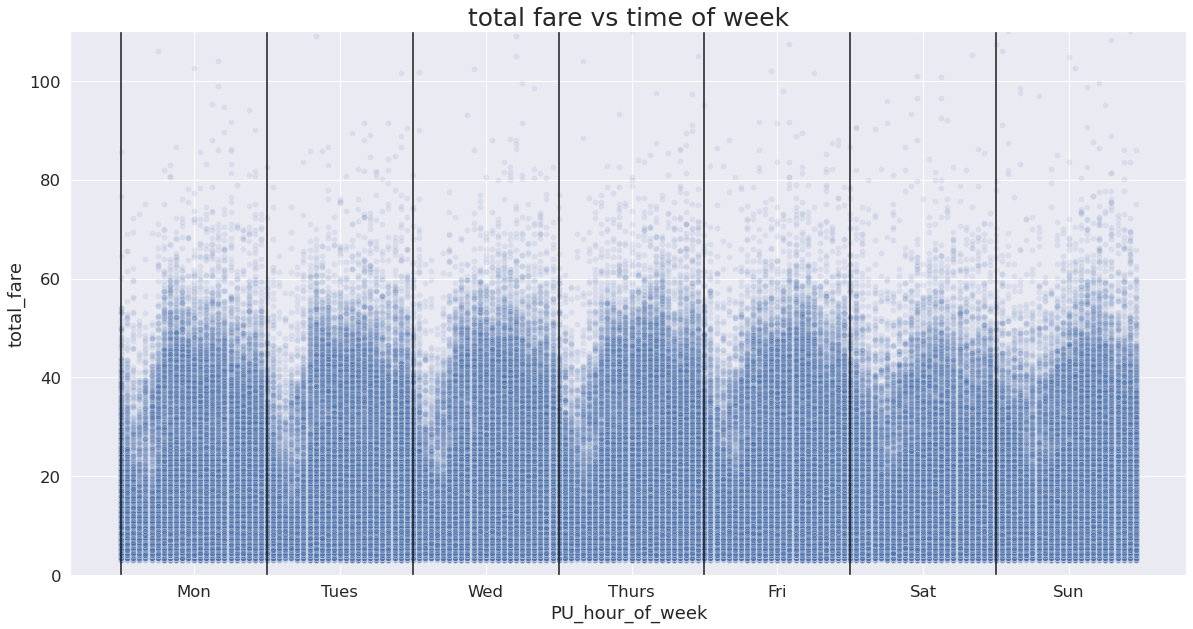

In [21]:
plt.figure(figsize = (20,10))
ax = sns.scatterplot(data=df_train, x="PU_hour_of_week", y="total_fare", alpha = .1)
for i in range(0,7):
    ax.vlines(i*24, -10, 110)
#sns.lineplot(data = df_train,  x="PU_hour_of_week", y="weekly_avg_fare", color='orange')
weekday_xticks = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
plt.xticks([12, (1*24)+12, (2*24)+12, (3*24)+12, (4*24)+12, (5*24)+12, (6*24)+12], weekday_xticks)
plt.ylim(0,110)
plt.title('total fare vs time of week', fontsize = 25)
plt.show()





More large fare trips in middle of the day and fewest at beginning. More long trips at end of day than beginning. Frequency of large fare trips seems to be lowest in early morning around 4am and largest around noon - 4pm. 

- This may be because more people tend to take long trips in the early afternoon, rather than that the fare rate itself is more expensive at these times of day. The fact that more people tend to travel large distances at a given time of day is not going to influence the average fare for any given person. 
- Also, there may be less traffic at certain times of day leading to longer trips and larger fares. Thus, the average duration per trip over different times of day is likely to be predictive of the fare. 

To predict fare, we should get a sense of how average trip duration varies over different times of week and year for different start and end points.  

In [22]:
df_train['trip_duration'] = df_train['tpep_dropoff_datetime'] - df_train['tpep_pickup_datetime']
df_train['trip_duration (mins)'] = df_train['trip_duration'].dt.total_seconds() / 60.0
df_train.drop('trip_duration', axis=1)

index  VendorID      tpep_pickup_datetime  \
0              0         2 2017-05-01 07:09:22+00:00   
1              1         2 2017-05-01 10:19:40+00:00   
2              2         2 2017-05-01 14:25:16+00:00   
3              3         1 2017-05-01 16:13:59+00:00   
4              4         2 2017-01-25 09:16:29+00:00   
...          ...       ...                       ...   
1075011  1091427         1 2017-07-31 14:53:07+00:00   
1075012  1091428         1 2017-07-31 16:31:34+00:00   
1075013  1091429         2 2017-07-31 19:44:26+00:00   
1075014  1091430         1 2017-09-11 06:51:13+00:00   
1075015  1091431         2 2017-09-11 08:29:59+00:00   

            tpep_dropoff_datetime  passenger_count  trip_distance  RatecodeID  \
0       2017-05-01 07:18:07+00:00                1           1.39           1   
1       2017-05-01 10:35:33+00:00                6           1.79           1   
2       2017-05-01 14:37:20+00:00                6           1.35           1   
3       2017-05-01 16:53:58+00:00                1           5.00           1   
4       2017-01-25 09:29:14+00:00                1           1.62           1   
...                           ...              ...            ...         ...   
1075011 2017-07-31 15:07:07+00:00                1           1.70           1   
1075012 2017-07-31 16:57:32+00:00                3           2.50           1   
1075013 2017-07-31 19:51:33+00:00                2           0.99           1   
1075014 2017-09-11 06:54:56+00:00                1           0.50           1   
1075015 2017-09-11 08:38:02+00:00                1           1.00           1   

         store_and_fwd_flag  PULocationID  DOLocationID  ...  DO_zone_borough  \
0                     False           140           162  ...        Manhattan   
1                     False           162           236  ...        Manhattan   
2                     False           236           239  ...        Manhattan   
3                     False           161            13  ...        Manhattan   
4                     False           186           163  ...        Manhattan   
...                     ...           ...           ...  ...              ...   
1075011               False           164            48  ...        Manhattan   
1075012               False           186            43  ...        Manhattan   
1075013               False            90           107  ...        Manhattan   
1075014               False            68            68  ...        Manhattan   
1075015               False           236           262  ...        Manhattan   

                                              DO_zone_geom  \
0        POLYGON((-73.970759194 40.7558248509999, -73.9...   
1        POLYGON((-73.9572940999999 40.7742835549999, -...   
2        POLYGON((-73.9763914919999 40.7882667469999, -...   
3        POLYGON((-74.012554689 40.719069863, -74.01270...   
4        POLYGON((-73.9814146949998 40.7677778729999, -...   
...                                                    ...   
1075011  POLYGON((-73.9907263629999 40.7559504059999, -...   
1075012  POLYGON((-73.972098524 40.7655172509999, -73.9...   
1075013  POLYGON((-73.982322826 40.7314978899999, -73.9...   
1075014  POLYGON((-74.0015553149999 40.7410800259999, -...   
1075015  MULTIPOLYGON(((-73.9380672308988 40.7809447032...   

                                  DO_zone_center  PU_DO_straightline_distance  \
0         (-73.97261531167338, 40.7565299845101)                     1.176239   
1        (-73.9571287107499, 40.780276118538374)                     1.162406   
2        (-73.98318459098333, 40.78479699627972)                     1.802919   
3        (-74.01732606477353, 40.70941905728343)                     2.913303   
4         (-73.9787581414772, 40.76555919693171)                     0.969320   
...                                          ...                          ...   
1075011  (-73.99073528001917, 40.76141002298066)                     0.481686   

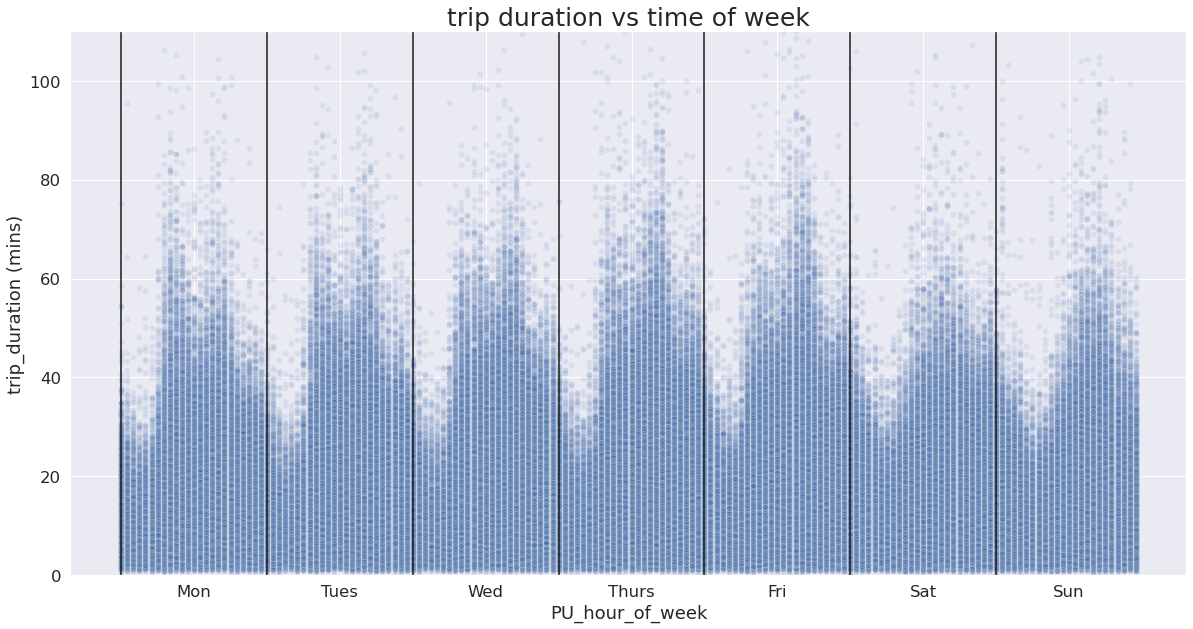

In [23]:
plt.figure(figsize = (20,10))
ax = sns.scatterplot(data=df_train, x="PU_hour_of_week", y="trip_duration (mins)", alpha = .1)
for i in range(0,7):
    ax.vlines(i*24, -10, 110)
#sns.lineplot(data = df_train,  x="PU_hour_of_week", y="weekly_avg_fare", color='orange')
weekday_xticks = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
plt.xticks([12, (1*24)+12, (2*24)+12, (3*24)+12, (4*24)+12, (5*24)+12, (6*24)+12], weekday_xticks)
plt.ylim(0,110)
plt.title('trip duration vs time of week', fontsize = 25)
plt.show()

Duration follows similar pattern to fare. There's a little dip in the middle of the day during the week, probably reflecting the fact that many people are having lunch. Like fare, duration can also vary depending on how many people take long trips over different points in the week. What we really want, in order to use time of week as a predictor, is variation of duration for fixed pickup and dropoff points. Naturally, we can expect this to vary depending on the pickup and dropoff points. What we want is to unders

In [24]:
df_train.columns

Index(['index', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'hashrow', 'total_fare', 'trip_distance_binned',
       'total_fare_binned_avg', 'total_fare_binned_std', 'PU_zone_ID',
       'PU_zone_name', 'PU_zone_borough', 'PU_zone_geom', 'PU_zone_center',
       'DO_zone_ID', 'DO_zone_name', 'DO_zone_borough', 'DO_zone_geom',
       'DO_zone_center', 'PU_DO_straightline_distance',
       'PU_DO_straightline_distance_binned',
       'PU_DO_straightline_distance_binned_avg',
       'PU_DO_straightline_distance_binned_std', 'PU_day_of_week',
       'PU_hour_of_week', 'trip_duration', 'trip_duration (mins)'],
      dtype='object')

Get count, sorted in descending order, for each pair of pickup and dropoff location. 

In [46]:
df_temp = df_train[['PULocationID', 'DOLocationID', 'total_fare']].groupby(['PULocationID', 'DOLocationID']).count().rename({'total_fare':'count'}, axis=1).sort_values('count', ascending=False)

In [47]:
df_temp

count
PULocationID DOLocationID       
237          236            6313
236          237            5063
             236            4921
237          237            4583
239          238            3023
...                          ...
146          65                1
             53                1
             35                1
             26                1
143          217               1

[14625 rows x 1 columns]

View dependence on time of week of total fare and duration of trips with fixed pickup and dropoff

In [60]:
def plot_avg_total_fare_for_fixed_pu_do(df, pu_location_id, do_location_id):
    df = df[(df['PULocationID']==pu_location_id) & (df['DOLocationID']==do_location_id)]
    plt.figure(figsize = (20,10))
    ax = sns.scatterplot(data=df, x="PU_hour_of_week", y="trip_duration (mins)", alpha = .1)
    #for i in range(0,7):
        #ax.vlines(i*24, -10, 110)
    #sns.lineplot(data = df_train,  x="PU_hour_of_week", y="weekly_avg_fare", color='orange')
    weekday_xticks = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
    plt.xticks([12, (1*24)+12, (2*24)+12, (3*24)+12, (4*24)+12, (5*24)+12, (6*24)+12], weekday_xticks)
    plt.ylim(0,50)
    plt.title('trip duration vs time of week', fontsize = 25)
    plt.show()
    return ax

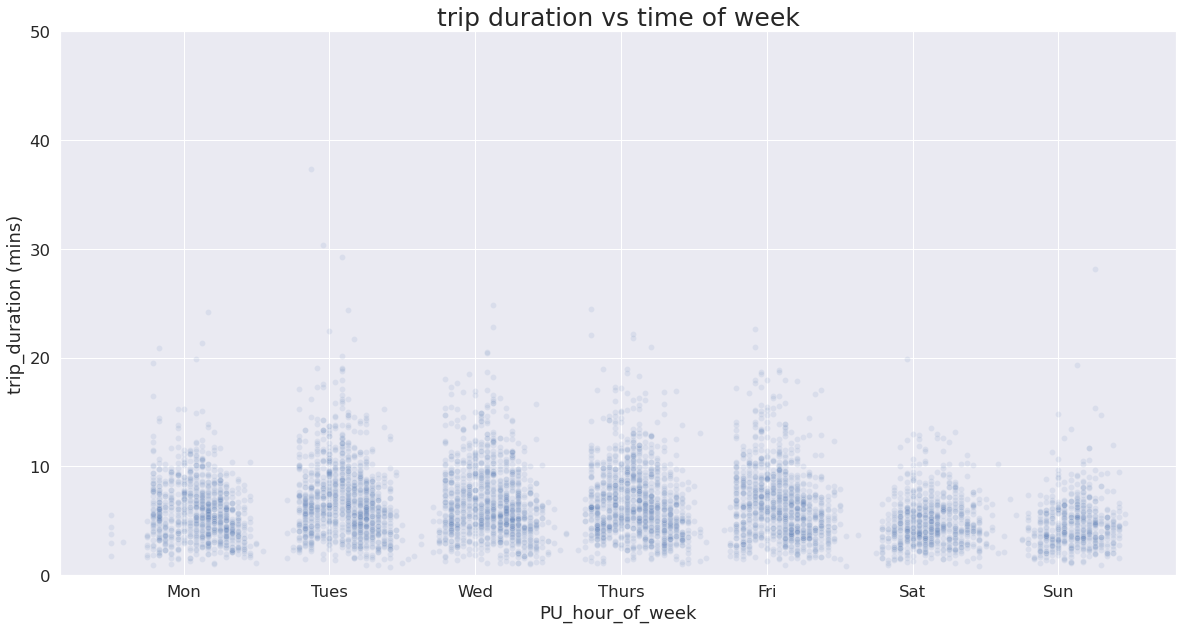

In [61]:
pu_location_id = 237
do_location_id = 236
plot_avg_total_fare_for_fixed_pu_do(df_train, pu_location_id, do_location_id)

In [65]:
df_geom[df_geom['zone_id']==237]

zone_id              zone_name    borough  \
233      237  Upper East Side South  Manhattan   

                                             zone_geom  \
233  POLYGON((-73.9656696 40.7628045559999, -73.965...   

                                  zone_center  
233  (-73.96565668716319, 40.768468855632555)

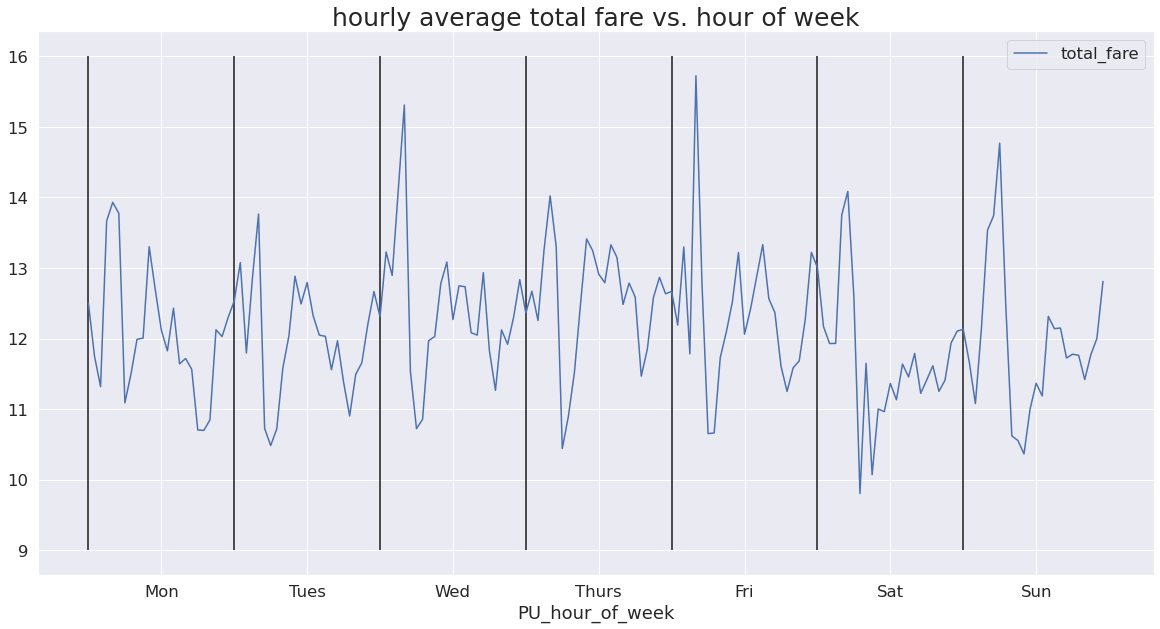

In [16]:
ax = df_train[["PU_hour_of_week", "total_fare"]].groupby('PU_hour_of_week').mean().plot(figsize=(20,10))
for i in range(0,7):
    ax.vlines(i*24, 9, 16)
weekday_xticks = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
plt.title('hourly average total fare vs. hour of week', fontsize=25)
plt.xticks([12, (1*24)+12, (2*24)+12, (3*24)+12, (4*24)+12, (5*24)+12, (6*24)+12], weekday_xticks)
plt.show()

The second plot of hourly average fare shows a significant amount of periodicity per week. However, the first plot above shows a lot of variation in the fare arount this average.

In [18]:
df_train.columns

Index(['index', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'hashrow', 'total_fare', 'trip_distance_binned',
       'total_fare_binned_avg', 'total_fare_binned_std', 'PU_zone_ID',
       'PU_zone_name', 'PU_zone_borough', 'PU_zone_geom', 'PU_zone_center',
       'DO_zone_ID', 'DO_zone_name', 'DO_zone_borough', 'DO_zone_geom',
       'DO_zone_center', 'PU_DO_straightline_distance',
       'PU_DO_straightline_distance_binned',
       'PU_DO_straightline_distance_binned_avg',
       'PU_DO_straightline_distance_binned_std', 'PU_day_of_week',
       'PU_hour_of_week'],
      dtype='object')

In [25]:
df_train['PU_zone_borough'].head()

0    Manhattan
1       Queens
2    Manhattan
3    Manhattan
4    Manhattan
Name: PU_zone_borough, dtype: object

In [26]:
df_train[df_train['PU_zone_borough'] == 'Manhattan']

index  VendorID      tpep_pickup_datetime     tpep_dropoff_datetime  \
0            0         2 2017-08-21 14:45:44+00:00 2017-08-21 14:48:51+00:00   
2            2         2 2017-03-10 17:01:57+00:00 2017-03-10 17:17:59+00:00   
3            3         1 2017-12-01 12:47:06+00:00 2017-12-01 13:11:40+00:00   
4            4         1 2017-02-01 08:32:25+00:00 2017-02-01 08:59:55+00:00   
5            5         1 2017-06-08 17:47:10+00:00 2017-06-08 17:59:31+00:00   
...        ...       ...                       ...                       ...   
108288  109904         2 2017-08-07 21:23:17+00:00 2017-08-07 21:40:25+00:00   
108289  109905         1 2017-10-08 17:39:16+00:00 2017-10-08 17:47:08+00:00   
108290  109906         1 2017-08-19 01:17:05+00:00 2017-08-19 01:24:34+00:00   
108291  109907         1 2017-07-21 00:07:16+00:00 2017-07-21 00:33:28+00:00   
108292  109908         2 2017-08-09 15:58:24+00:00 2017-08-09 16:02:45+00:00   

        passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0                     1           0.78           1               False   
2                     1           1.78           1               False   
3                     1           2.00           1               False   
4                     1           4.50           1               False   
5                     1           1.10           1               False   
...                 ...            ...         ...                 ...   
108288                4           4.86           1               False   
108289                1           1.10           1               False   
108290                1           0.90           1               False   
108291                1           4.30           1               False   
108292                1           0.61           1               False   

        PULocationID  DOLocationID  ...                  DO_zone_name  \
0                263           141  ...               Lenox Hill West   
2                107           186  ...  Penn Station/Madison Sq West   
3                144           234  ...                      Union Sq   
4                 13           230  ...     Times Sq/Theatre District   
5                161           142  ...           Lincoln Square East   
...              ...           ...  ...                           ...   
108288            79            33  ...              Brooklyn Heights   
108289           161           234  ...                      Union Sq   
108290           148           148  ...               Lower East Side   
108291            48             7  ...                       Astoria   
108292           162           170  ...                   Murray Hill   

        DO_zone_borough                                       DO_zone_geom  \
0             Manhattan  POLYGON((-73.961767665 40.7598930409999, -73.9...   
2             Manhattan  POLYGON((-73.9905176129999 40.7460386379999, -...   
3             Manhattan  POLYGON((-73.9899776669999 40.7349792549999, -...   
4             Manhattan  POLYGON((-73.9831679599999 40.7561402219999, -...   
5             Manhattan  POLYGON((-73.9814146949998 40.7677778729999, -...   
...                 ...                                                ...   
108288         Brooklyn  POLYGON((-73.9981387989944 40.7015187882484, -...   
108289        Manhattan  POLYGON((-73.9899776669999 40.7349792549999, -...   
108290        Manhattan  POLYGON((-73.9838642279999 40.7213963779999, -...   
108291           Queens  POLYGON((-73.9041889529999 40.767530285, -73.9...   
108292        Manhattan  POLYGON((-73.971944289 40.7459318719999, -73.9...   

                                  DO_zone_center  PU_DO_straightline_distance  \
0        (-73.96011248259249, 40.76562023407397)                     0.732013   
2        (-73.99198045716656, 40.74861054308323)                     0.579332   
3       (-73.99013101759174, 40.739311150122354)                     0.570901   
4         (-73.984299

## Cross Section of Temporal Dependence over PU/DO Borough

How does borough influence fare over time? 

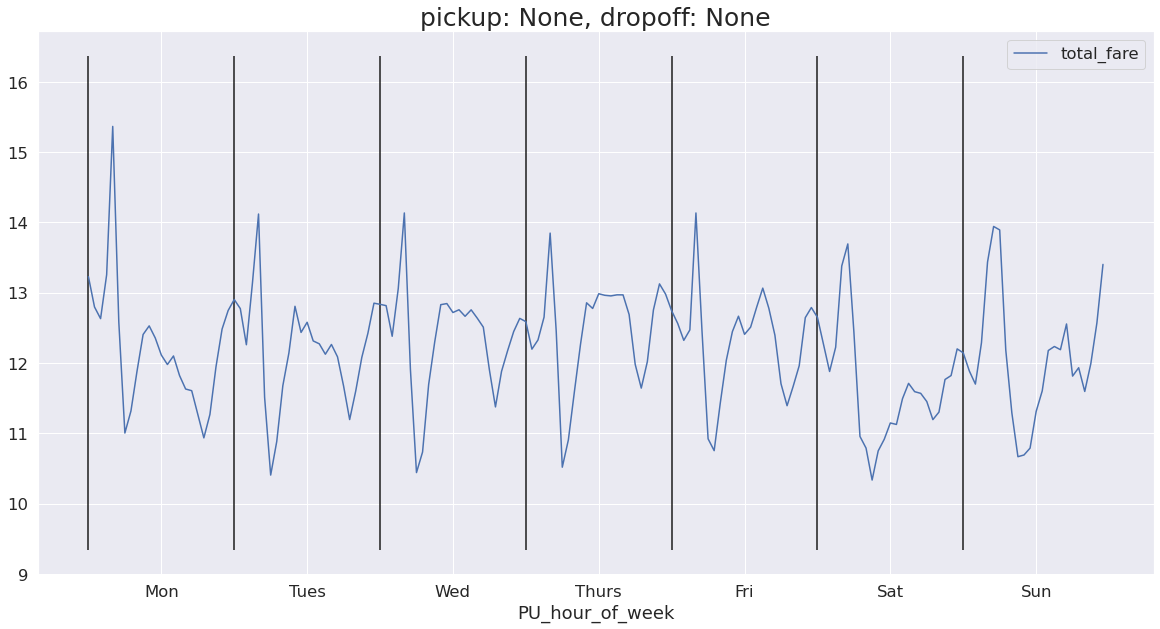

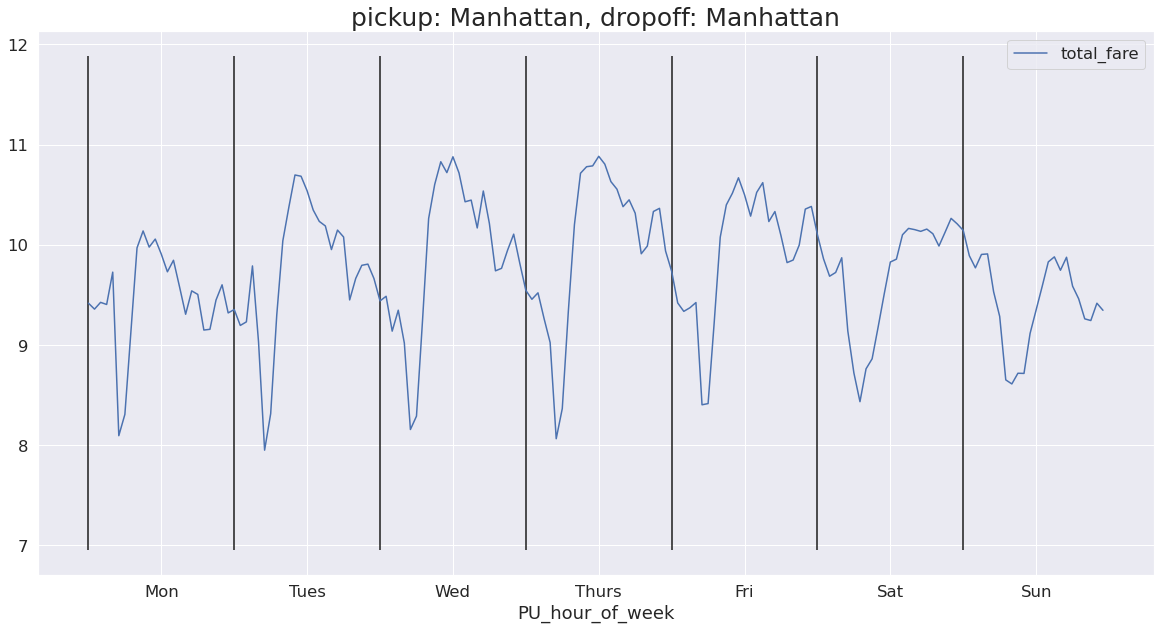

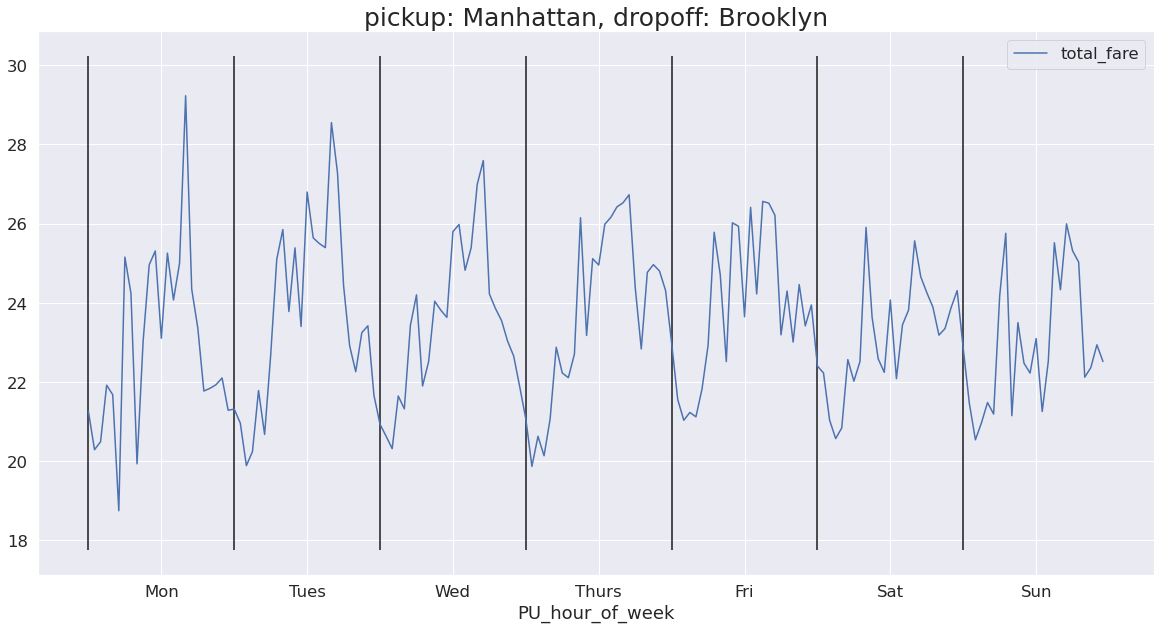

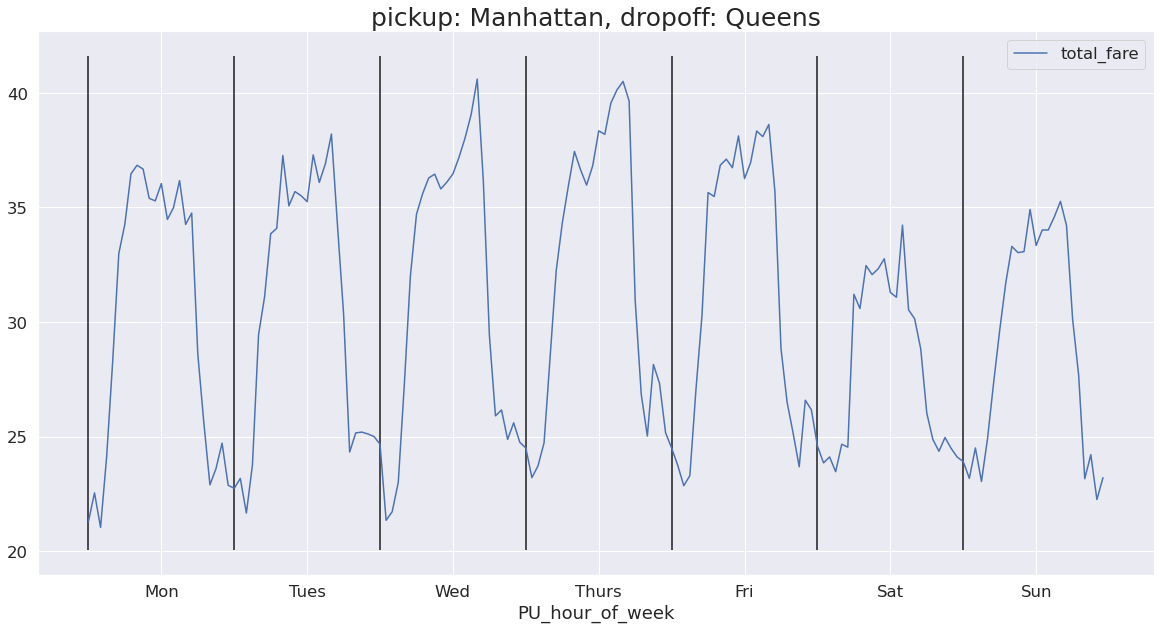

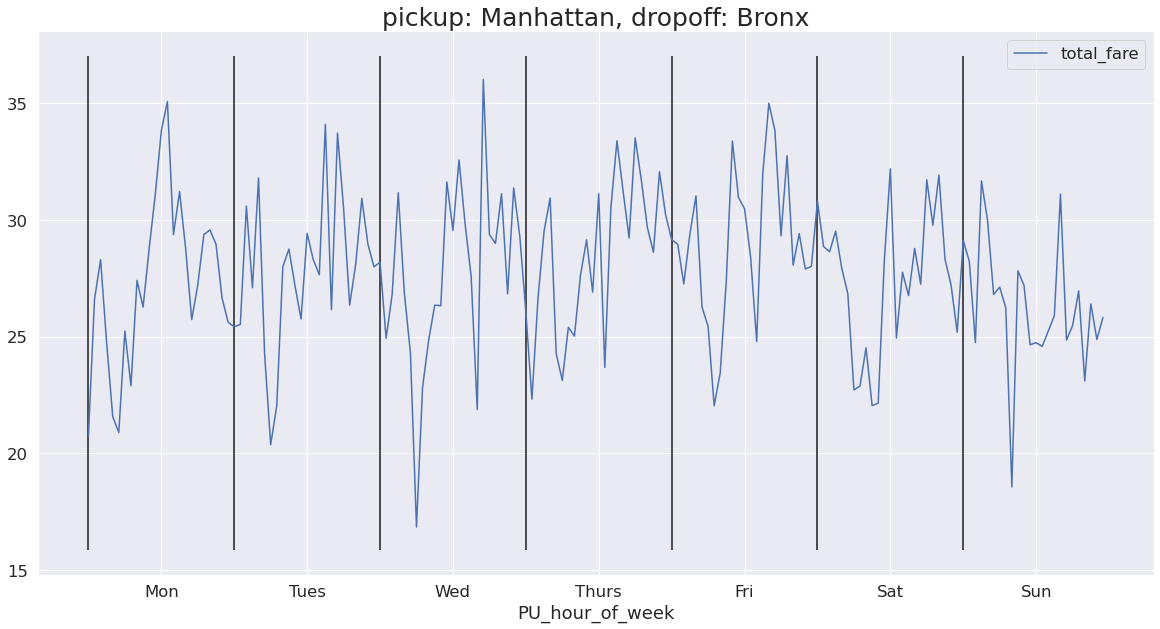

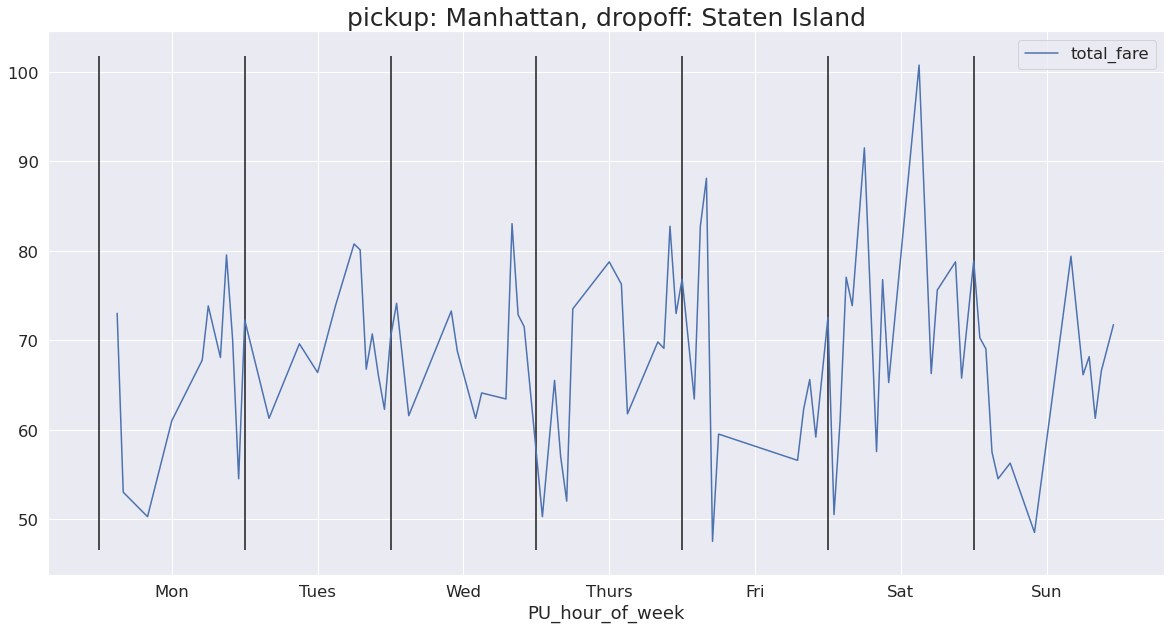

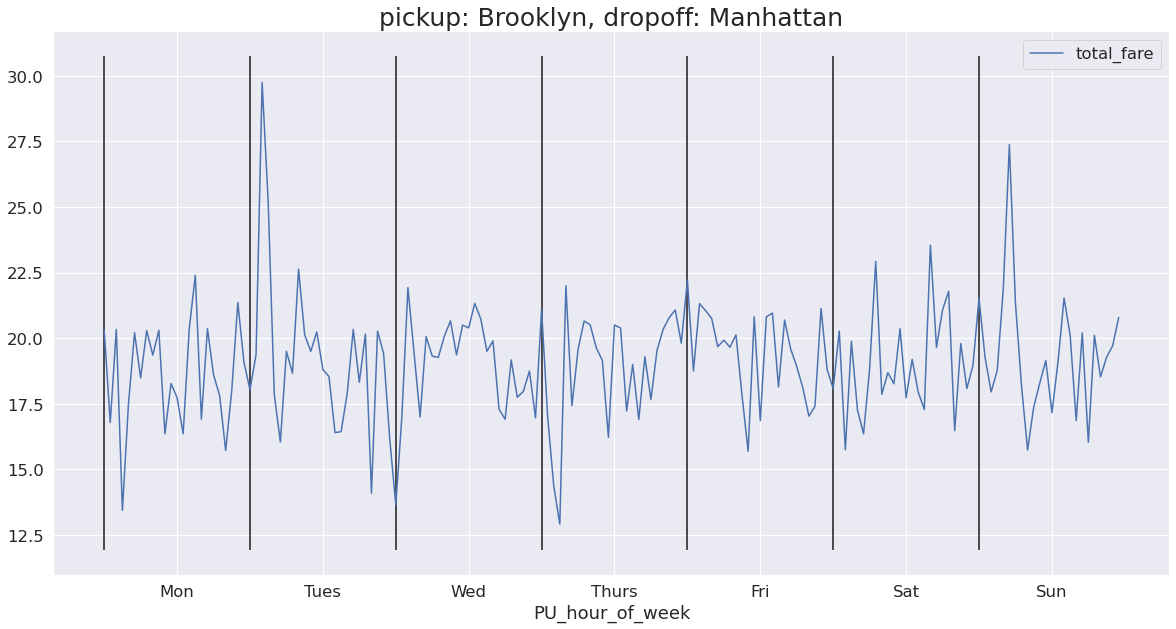

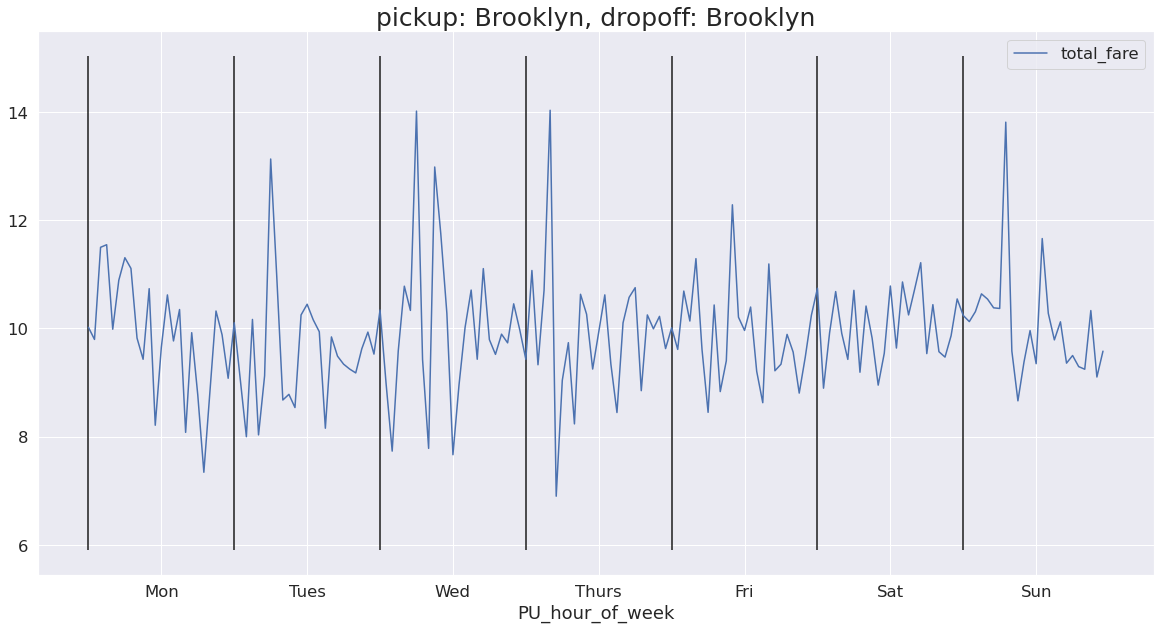

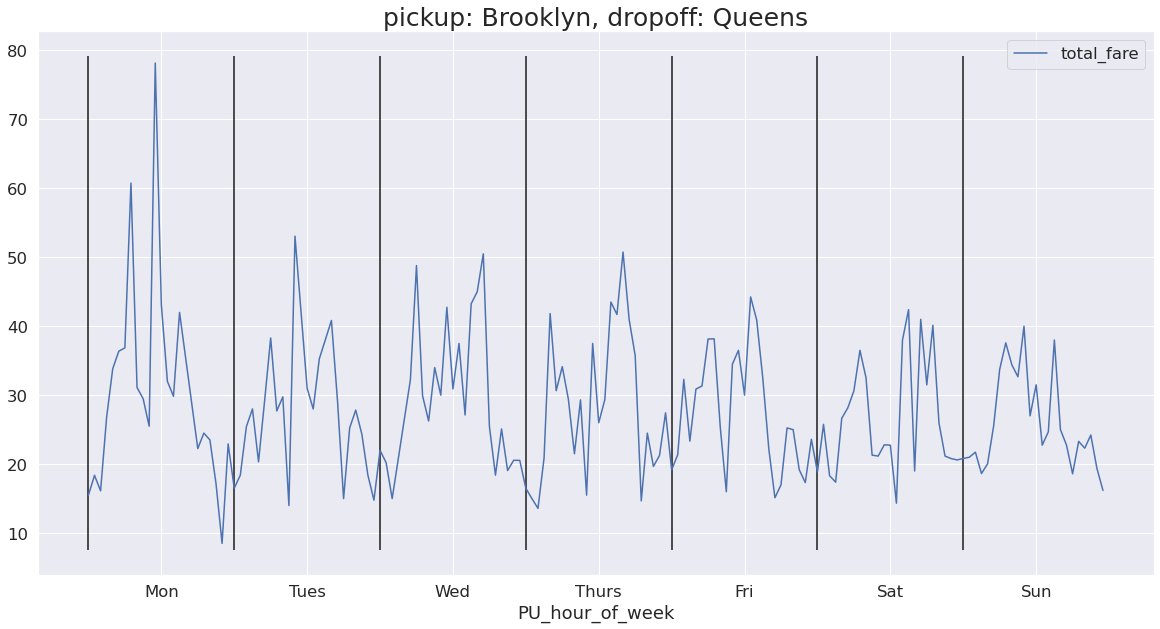

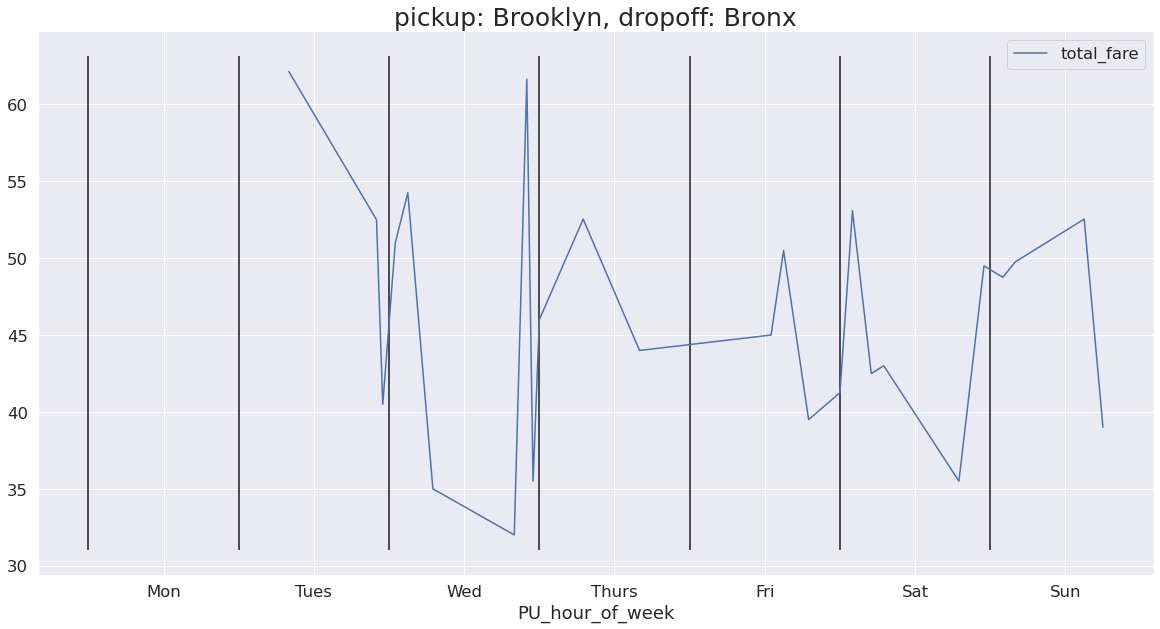

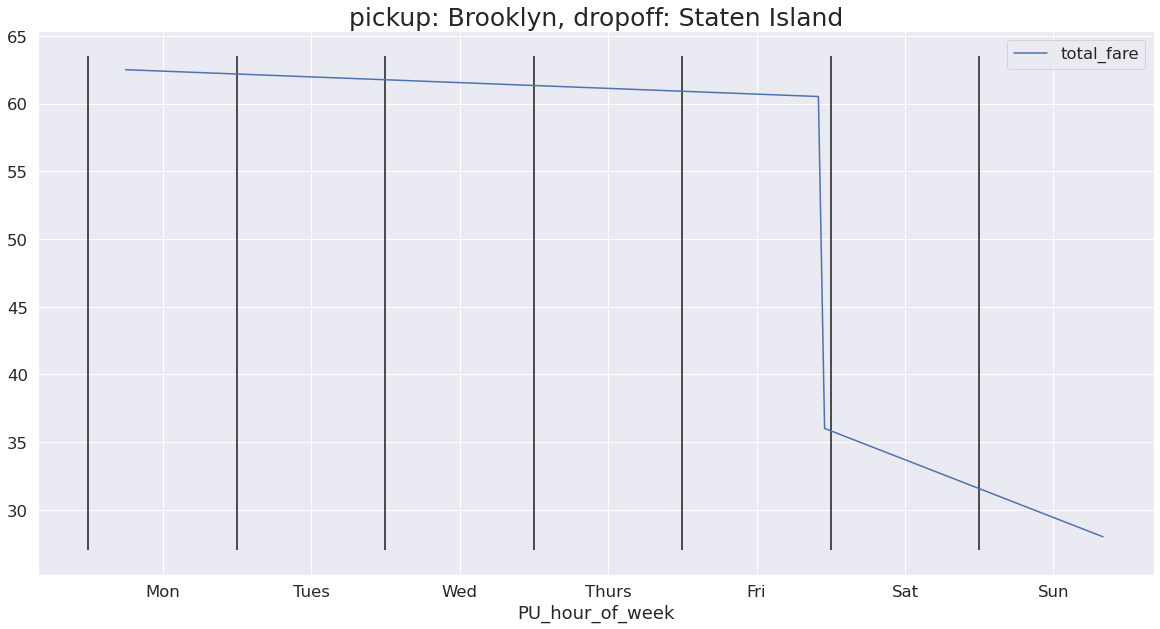

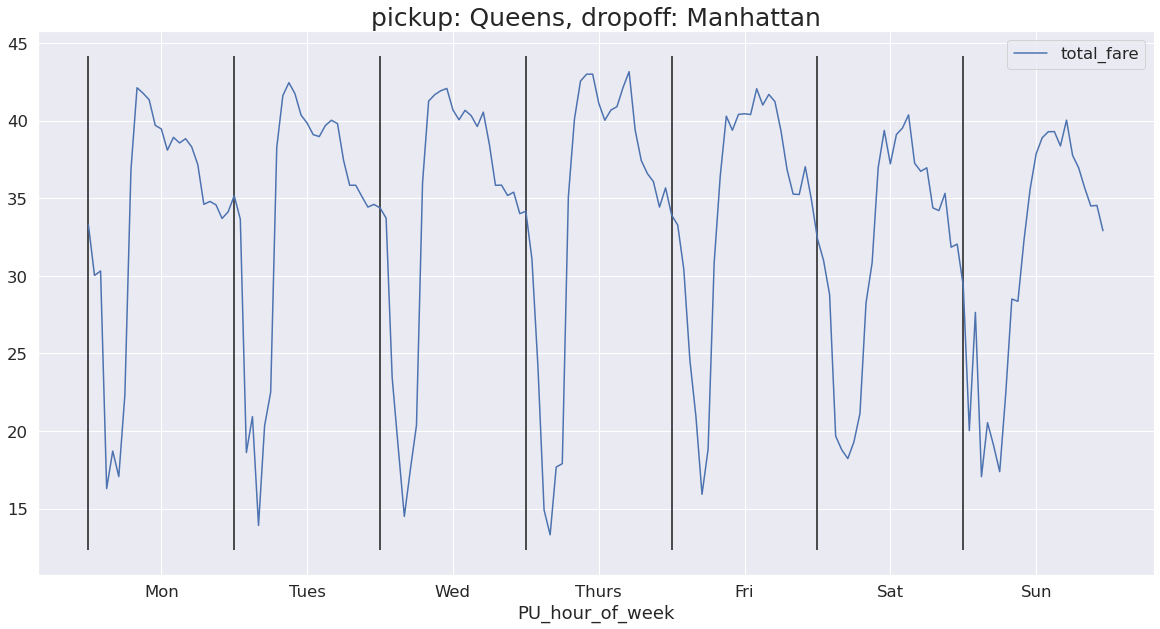

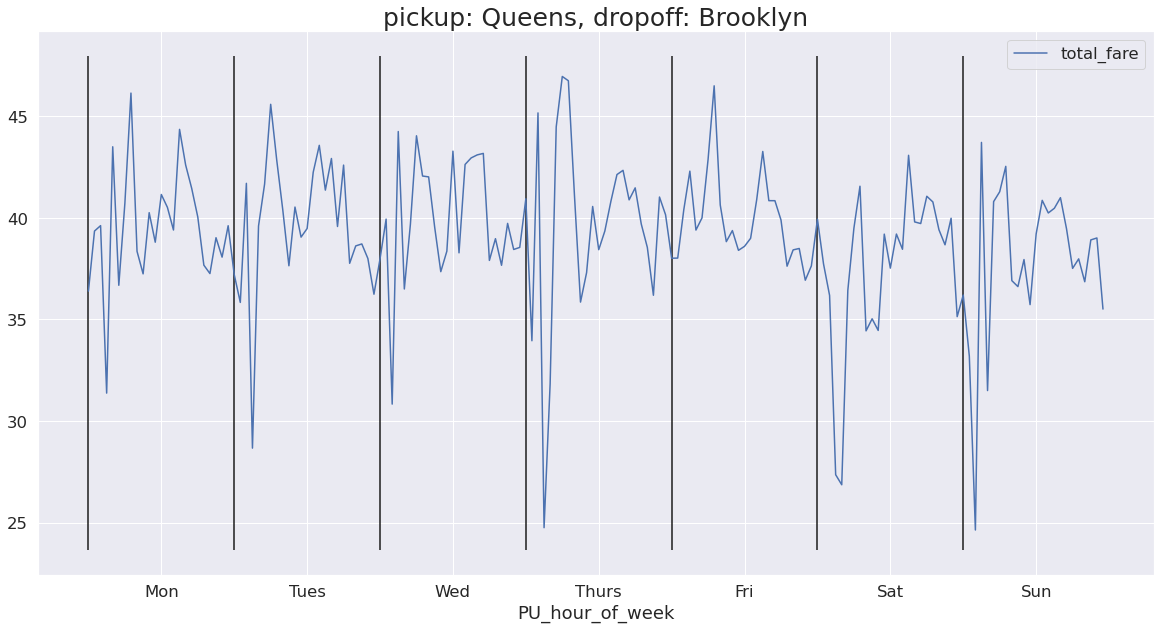

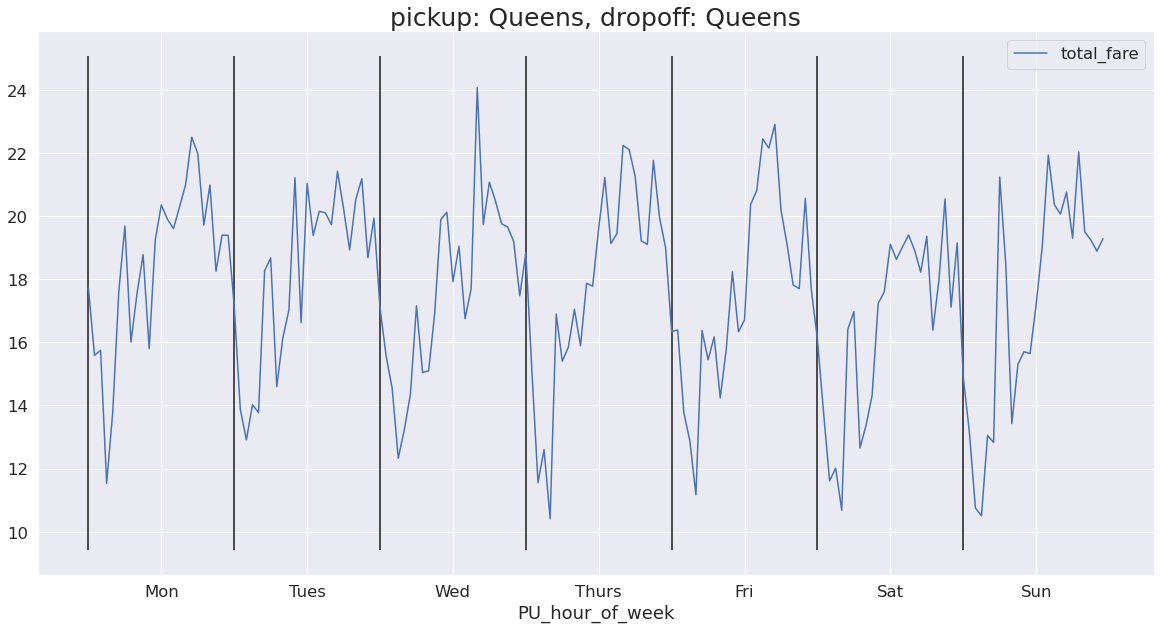

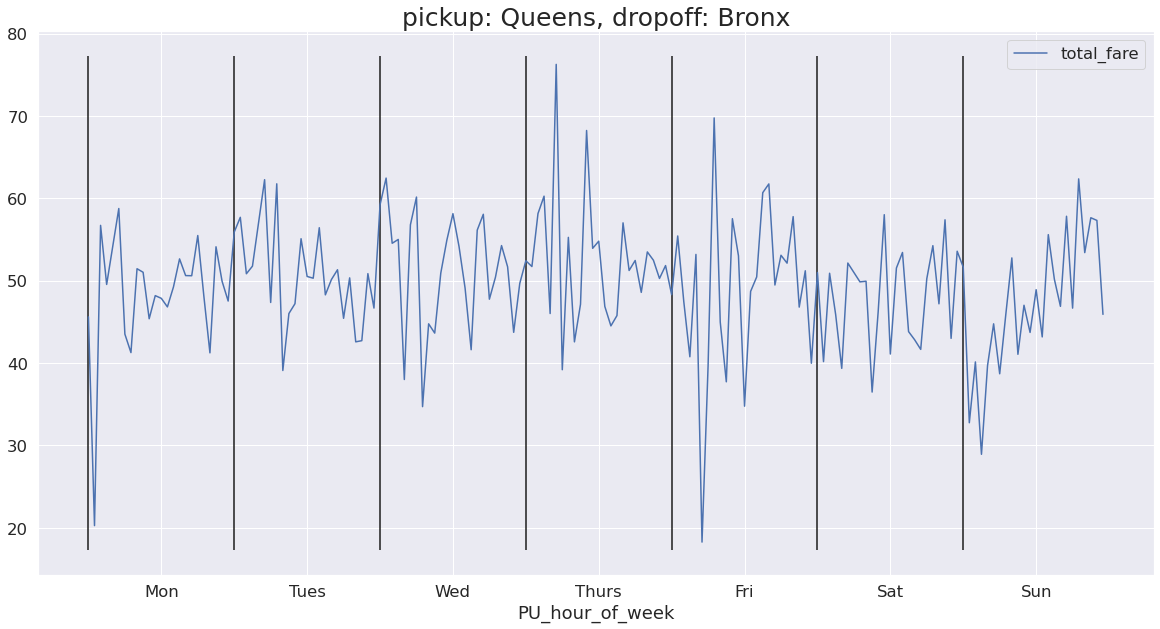

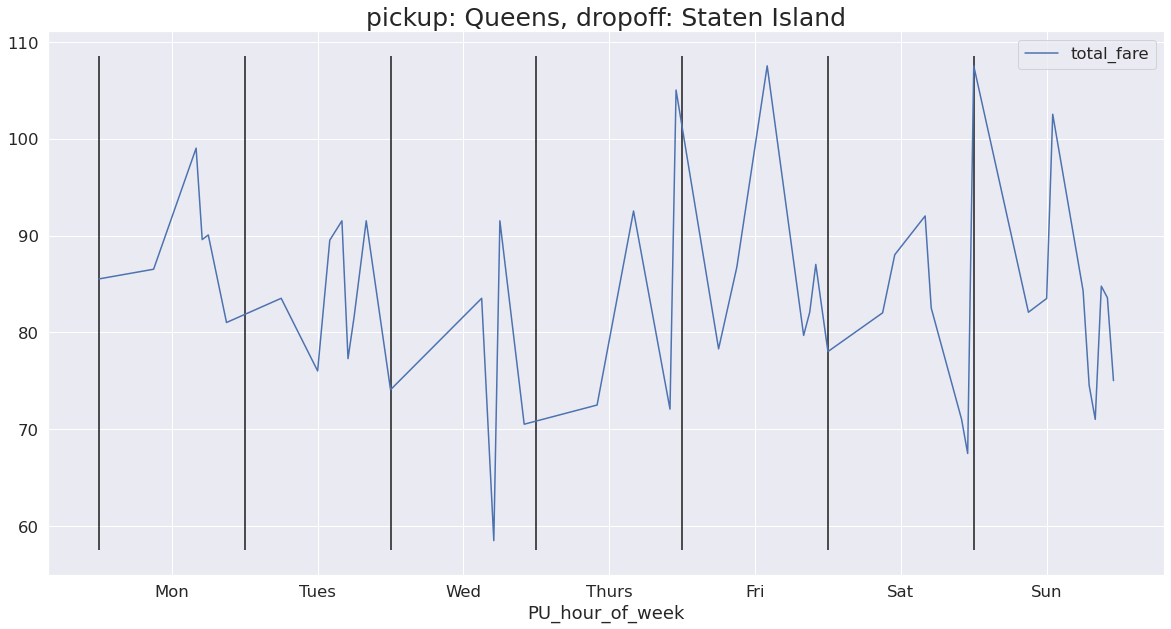

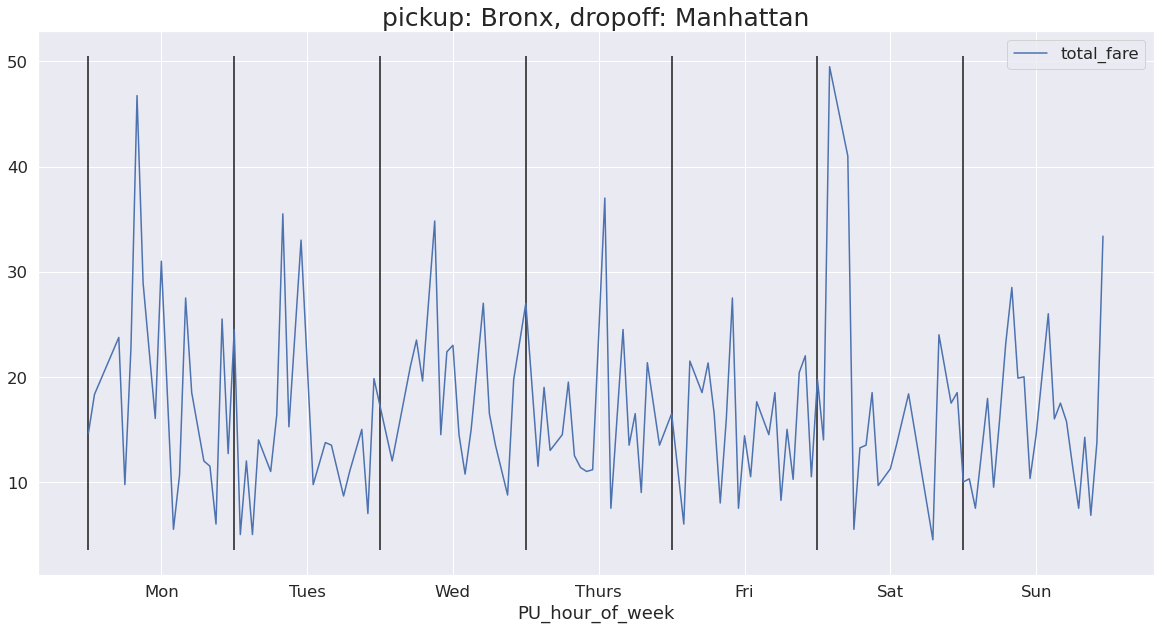

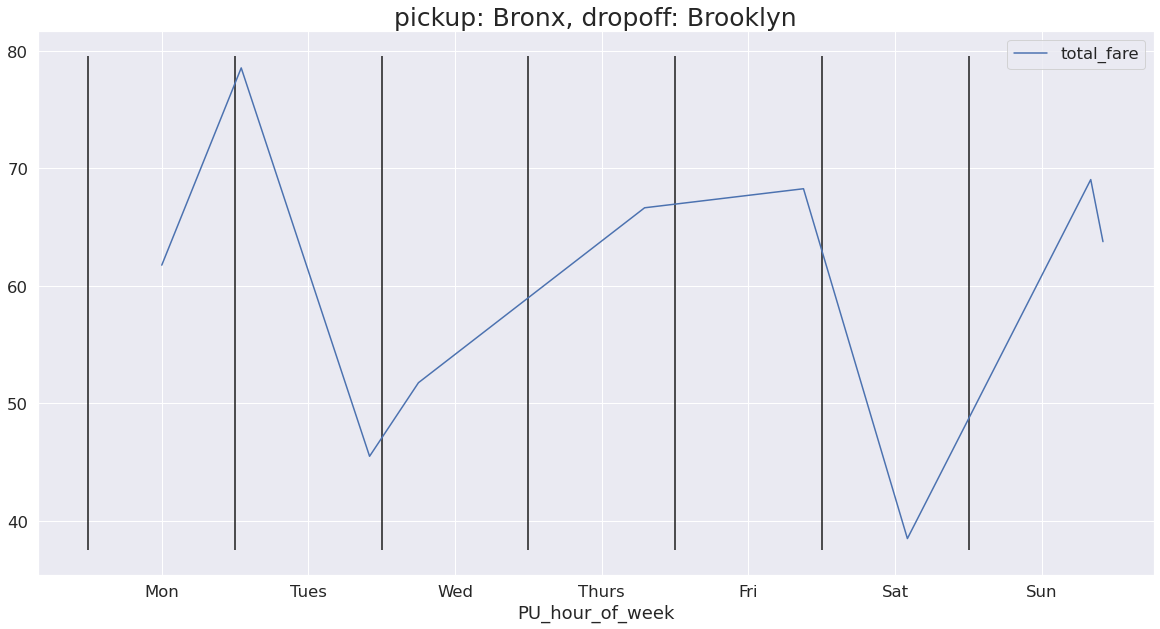

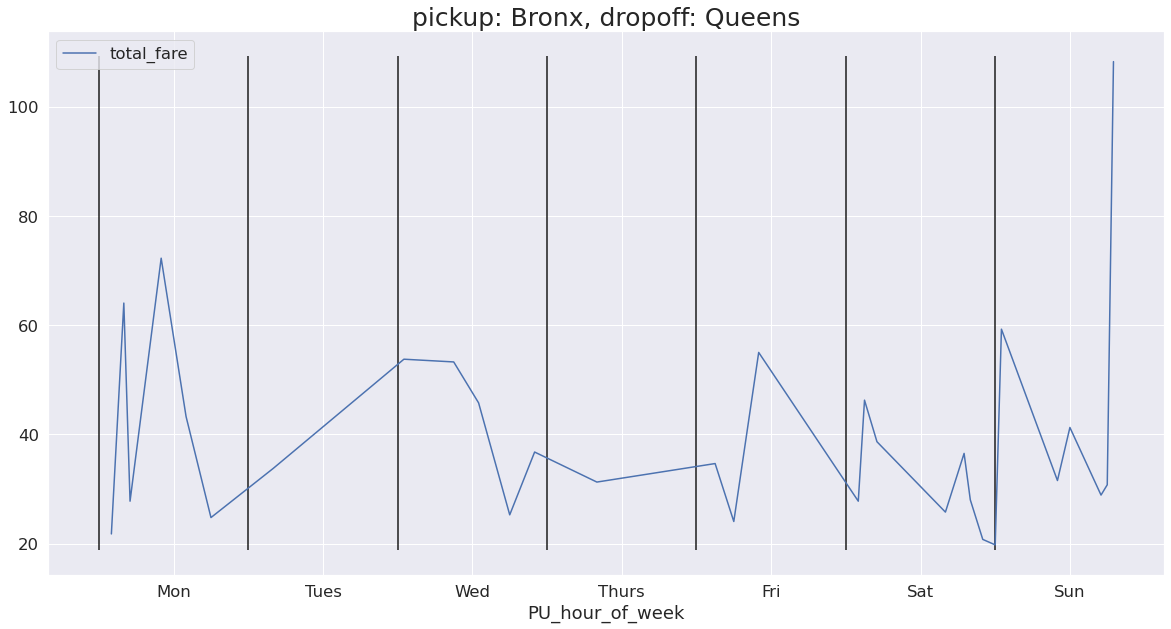

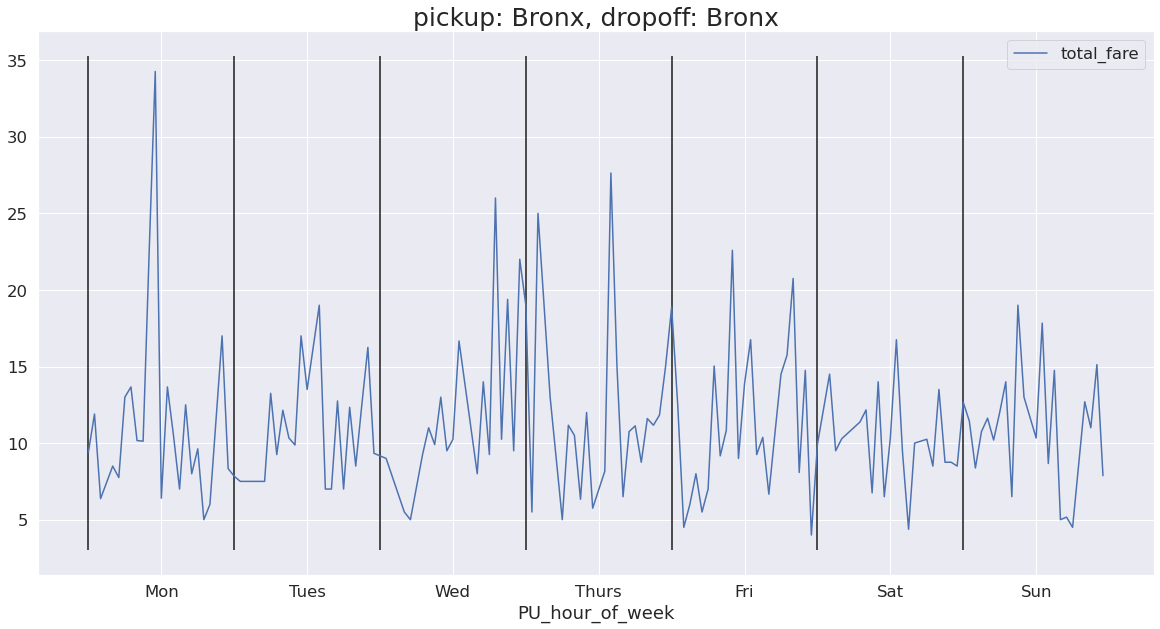

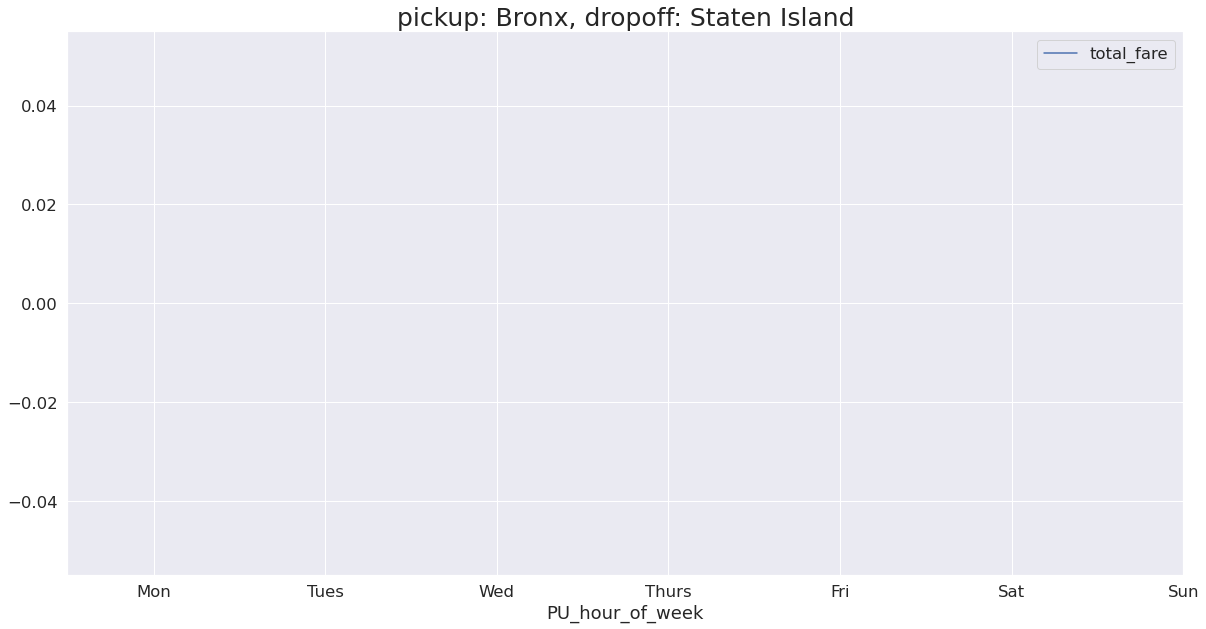

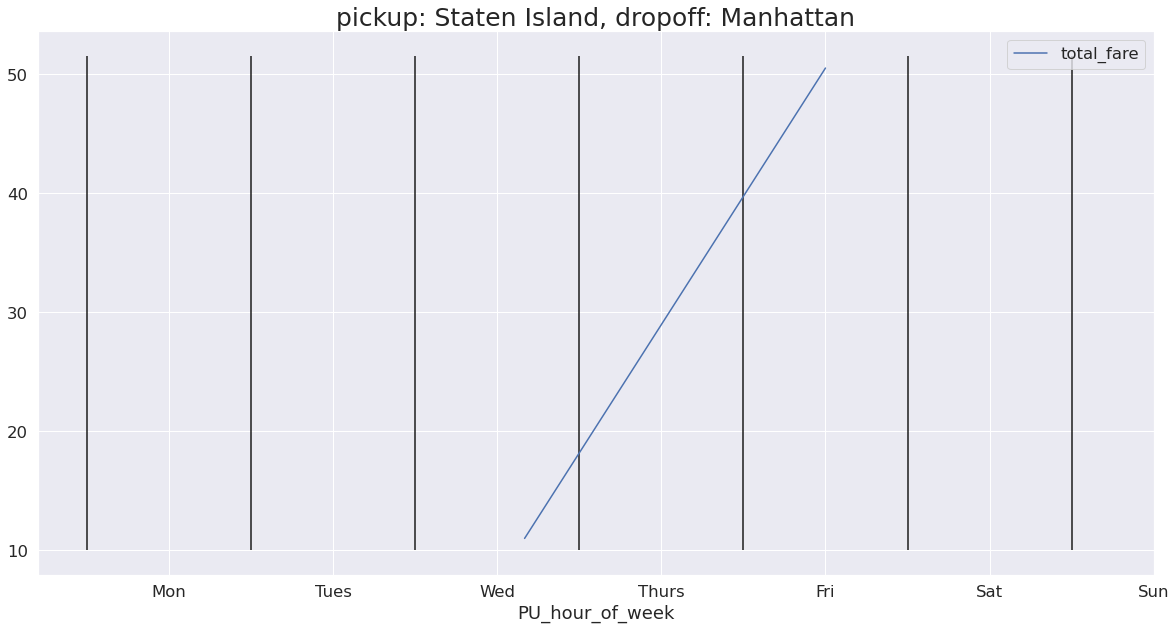

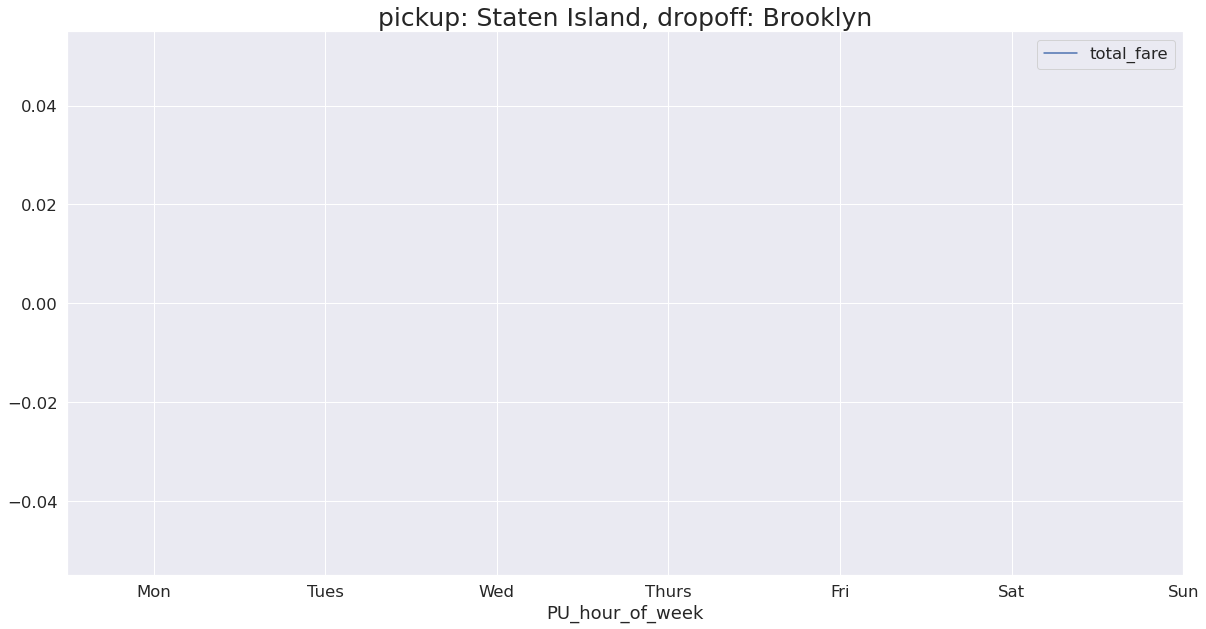

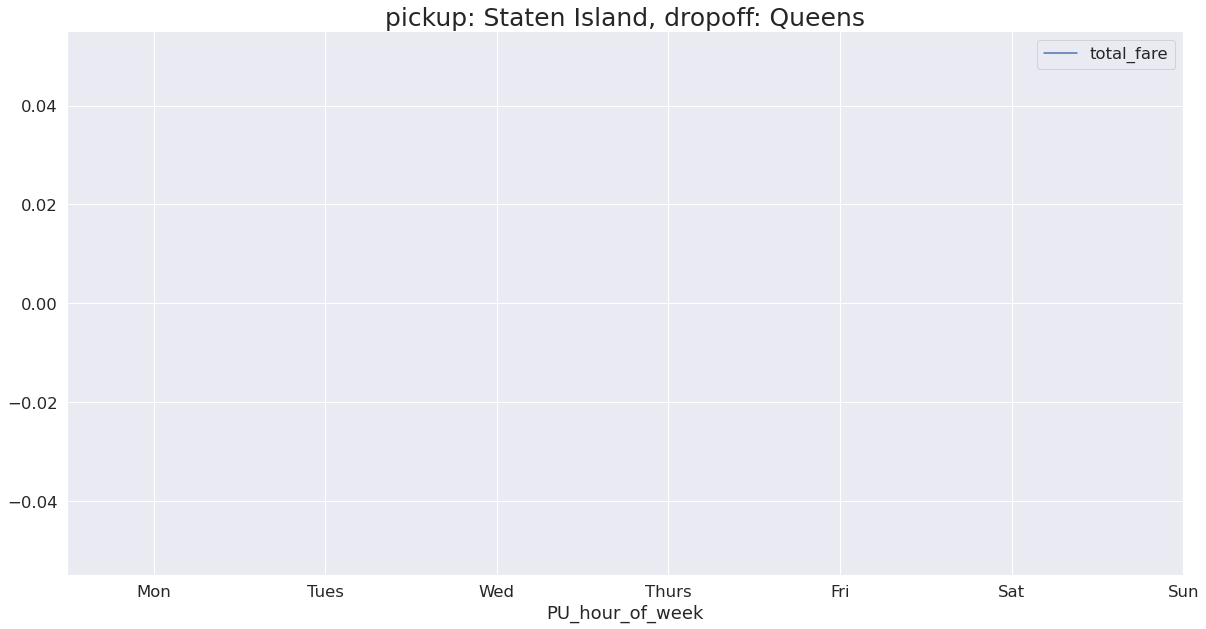

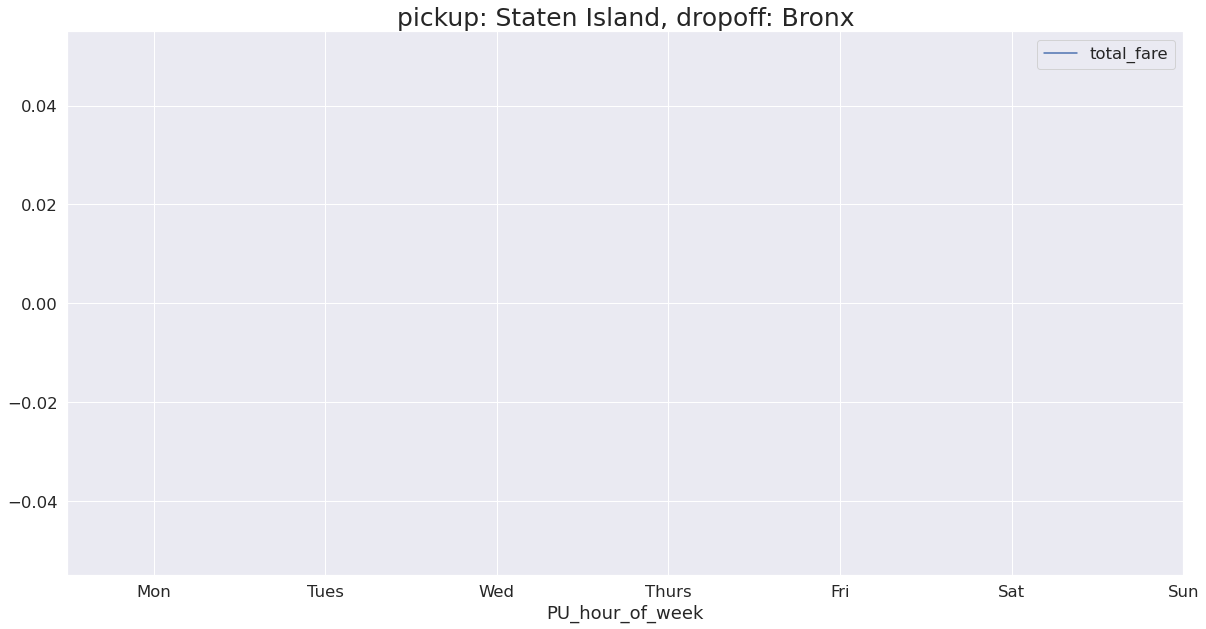

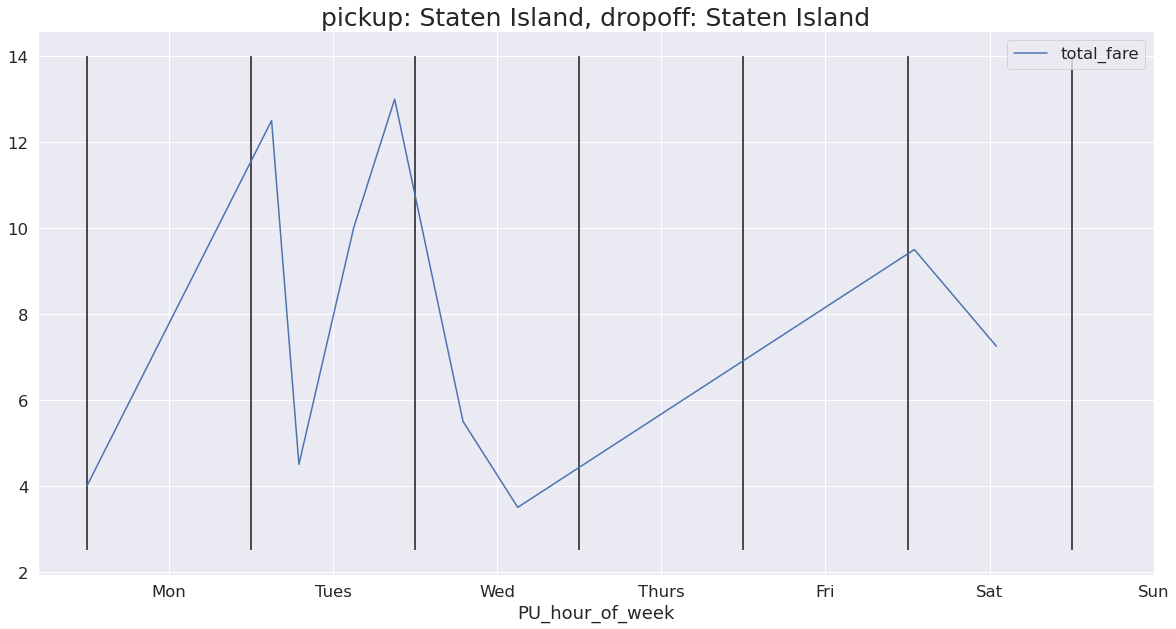

In [85]:
def plot_weekly_fare_time_dependence(df, pu_borough, do_borough):
    if not pu_borough or not do_borough:
        df_borough = df
    else:
        df_borough = df[(df['PU_zone_borough'] == pu_borough) & (df['DO_zone_borough'] == do_borough)]
    ax = df_borough[["PU_hour_of_week", "total_fare"]].groupby('PU_hour_of_week').mean().plot(figsize=(20,10))
    
    vline_min = df_borough[['PU_hour_of_week', 'total_fare']].groupby('PU_hour_of_week').mean()['total_fare'].min()
    vline_max = df_borough[['PU_hour_of_week', 'total_fare']].groupby('PU_hour_of_week').mean()['total_fare'].max()
    for i in range(0,7):
        ax.vlines(i*24, vline_min - 1, vline_max + 1)
    
    weekday_xticks = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
    plt.title(f'pickup: {pu_borough}, dropoff: {do_borough}', fontsize=25)
    plt.xticks([12, (1*24)+12, (2*24)+12, (3*24)+12, (4*24)+12, (5*24)+12, (6*24)+12], weekday_xticks)
    plt.show()


boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
borough_pairs = [(i,j) for i in boroughs for j in boroughs]

#plot aggregate
plot_weekly_fare_time_dependence(df_train, None, None)
#plot for individual borough pairs
for pair in borough_pairs:
    pu_borough = pair[0]
    do_borough = pair[1]
    plot_weekly_fare_time_dependence(df_train, pu_borough, do_borough)



## Using Predicted Trip Distance as a Feature

Strictly speaking, trip distance is not known in advance because of traffic, road closures, different routes preferred by different drivers, etc. Try to predict trip distance and use this as a feature. Determine what factors most influence trip distance and average trip distance over groupings based on these factors.  

## Scrap Code

In [ ]:

'''
 # bin in .25 mile intervals of distance
distance_bins = [.25* i for i in range(int(50/.25))]
df_cleaned['PU_DO_straightline_distance_binned'] = pd.cut(df_cleaned['PU_DO_straightline_distance'], distance_bins)
# compute mean and std of total fare over trip distance bins, add them as new columns
df_temp = df_cleaned[['PU_DO_straightline_distance_binned', 'total_fare']].groupby('PU_DO_straightline_distance_binned').agg({'total_fare': ['mean', 'std']})
mean_std_dict = df_temp['total_fare'][['mean', 'std']].to_dict()
df_cleaned['PU_DO_straightline_distance_binned_avg'] = df_cleaned['PU_DO_straightline_distance_binned'].map(mean_std_dict['mean'])
df_cleaned['PU_DO_straightline_distance_binned_std'] = df_cleaned['PU_DO_straightline_distance_binned'].map(mean_std_dict['std'])

print('PLOTTING AVG TOTAL FARE VS. STRAIGHTLINE TRIP DISTANCE ...')
fig, ax = plt.subplots(figsize=(10,10))
plt.errorbar(df_cleaned['PU_DO_straightline_distance'], df_cleaned['PU_DO_straightline_distance_binned_avg'], yerr = df_cleaned['PU_DO_straightline_distance_binned_std'], fmt='o', color='blue',
             ecolor='gray', elinewidth=2)
plt.xlabel('PU_DO_straightline_distance', fontsize=14)
plt.ylabel('PU_DO_straightline_distance_binned_avg', fontsize=14)
plt.title('Average Total Fare vs. Straightline Trip Distance', fontsize=16)
plt.show()


In [ ]:
df_train['weekly_avg_fare'] = df_train[["PU_hour_of_week", "total_fare"]].groupby('PU_hour_of_week').mean()
df_temp = df_train[['PU_hour_of_week', 'weekly_avg_fare']].set_index('PU_hour_of_week')
df_temp.rolling(5).mean().head(200)
#df_train['weekly_avg_fare_rolling'] = df_temp['weekly_avg_fare'].rolling(5).mean()

In [ ]:
'''
def plot_weekly_fare_time_dependence(df, pu_borough, do_borough):
    plt.figure(figsize = (20,10))
    df_borough = df[df['']]
    
    ax = sns.scatterplot(data=df, x="PU_hour_of_week", y="total_fare")
    for i in range(0,7):
        ax.vlines(i*24, -10, 110)
    sns.lineplot(data = df_train,  x="PU_hour_of_week", y="weekly_avg_fare", color='orange')
    weekday_xticks = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
    plt.xticks([12, (1*24)+12, (2*24)+12, (3*24)+12, (4*24)+12, (5*24)+12, (6*24)+12], weekday_xticks)
    plt.ylim(0,110)
    plt.title('total_fare vs hour of the week', fontsize = 25)
    plt.show()
'''
